<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [242]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split , cross_val_score ,cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

pd.options.display.max_rows = 300
pd.options.display.max_columns = 300
sns.set_style('darkgrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [243]:
house = pd.read_csv('./housing.csv')

In [244]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [245]:
#C (all) is non residential
house.MSZoning.value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [246]:
#drop all non-residential entries
drop_list = list(house[house['MSZoning']=="C (all)"].index)
house.drop(index = drop_list,inplace = True)

In [247]:
#create new feature age_sold before removing the columns
house['age_sold'] = house['YrSold']-house['YearRemodAdd']

In [248]:
#drop columns that is not a characteristic of house
not_house_char = ['Id','MoSold','YearBuilt','YearRemodAdd','SaleType','GarageYrBlt']
house.drop(columns =(not_house_char) , inplace = True)


In [249]:
#split 'fixed' and 'not fixed' variables.

fixed_var = ['MSSubClass','MSZoning','LotFrontage','LotArea','Street','Alley','LotShape',
             'LandContour','Utilities','LotConfig','LandSlope','Neighborhood','Condition1',
             'Condition2','BldgType','HouseStyle','RoofStyle','MasVnrArea','Foundation',
             'BsmtExposure','TotalBsmtSF','1stFlrSF','2ndFlrSF','GrLivArea','BsmtFullBath',
             'BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd',
             'Fireplaces','GarageType','GarageCars','GarageArea','PavedDrive','WoodDeckSF',
             'OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea',
             'MiscFeature','MiscVal','SaleCondition','SalePrice','YrSold','age_sold']
not_fixed = [i for i in house.columns if i not in fixed_var]

#columns that will be used to train Q1 model.
house_fixed = house[fixed_var]

#set aside columns 
house_renov = house[not_fixed]


In [250]:
house_fixed.isnull().sum().sort_values(ascending= False).head(10)

MiscFeature     1398
Alley           1361
LotFrontage      259
GarageType        79
BsmtExposure      38
MasVnrArea         8
age_sold           0
Condition1         0
TotalBsmtSF        0
Foundation         0
dtype: int64

In [251]:
#Fixed the easy null values first. The null values have meanings. 
house_fixed.loc[house_fixed['Alley'].isnull(),"Alley"] = "N"
house_fixed.loc[house_fixed['GarageType'].isnull(),"GarageType"] = "N"
house_fixed.loc[house_fixed['BsmtExposure'].isna(),"BsmtExposure"] = "N"

c:\users\chenz\anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [252]:
house_fixed[house_fixed['MiscFeature'].isnull()]["MiscVal"].value_counts()

0    1398
Name: MiscVal, dtype: int64

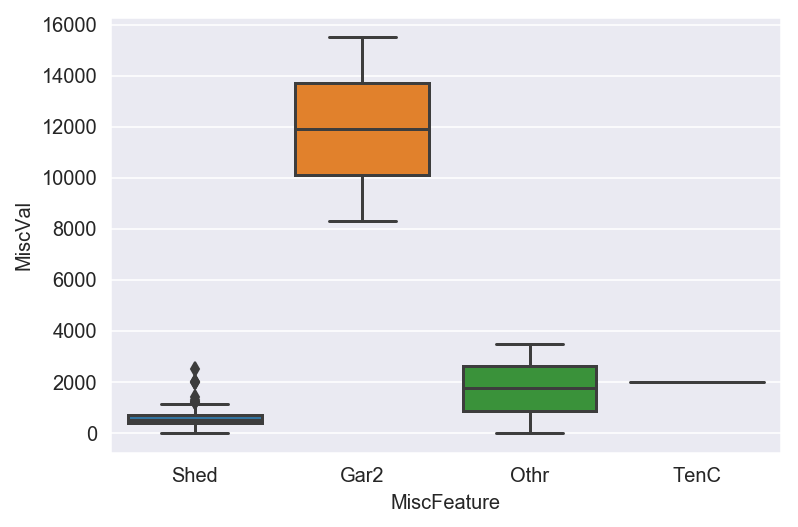

In [253]:
sns.boxplot(x = 'MiscFeature' , y ='MiscVal' , data = house_fixed )

In [254]:
#Decided to drop Misc Feature because "MiscVal" column will be able to represent it.
house_fixed.drop(columns = 'MiscFeature',inplace = True)

c:\users\chenz\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


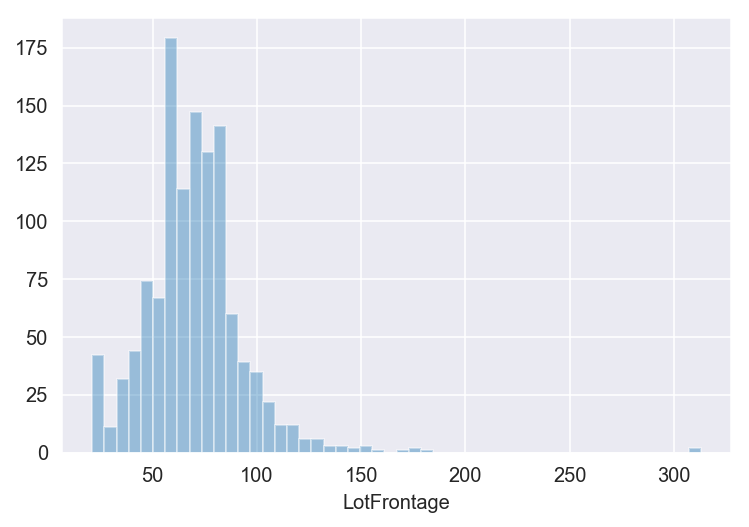

In [255]:
sns.distplot(house_fixed['LotFrontage'].dropna() , kde = False)

In [256]:
#decided to impute null value with mean
frontage_mean = np.mean(house_fixed['LotFrontage'].dropna())
#impute na with mean value
house_fixed.loc[house_fixed['LotFrontage'].isna(),"LotFrontage"] = frontage_mean


c:\users\chenz\anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [257]:
#check why MasVnrArea has null. Retrieve columns from main dataframe
house[house['MasVnrArea'].isnull()]['MasVnrType']

234     NaN
529     NaN
650     NaN
936     NaN
973     NaN
977     NaN
1243    NaN
1278    NaN
Name: MasVnrType, dtype: object

In [258]:
#MasVnrArea is Null value, because MasVnrType is None, meaning no Masonry Veneer
house_fixed['MasVnrArea'] = house_fixed['MasVnrArea'].replace(np.nan,0)

c:\users\chenz\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [259]:
#'MsSubclass' should be categorical type
house_fixed['MSSubClass'] = house_fixed['MSSubClass'].astype(str)

c:\users\chenz\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


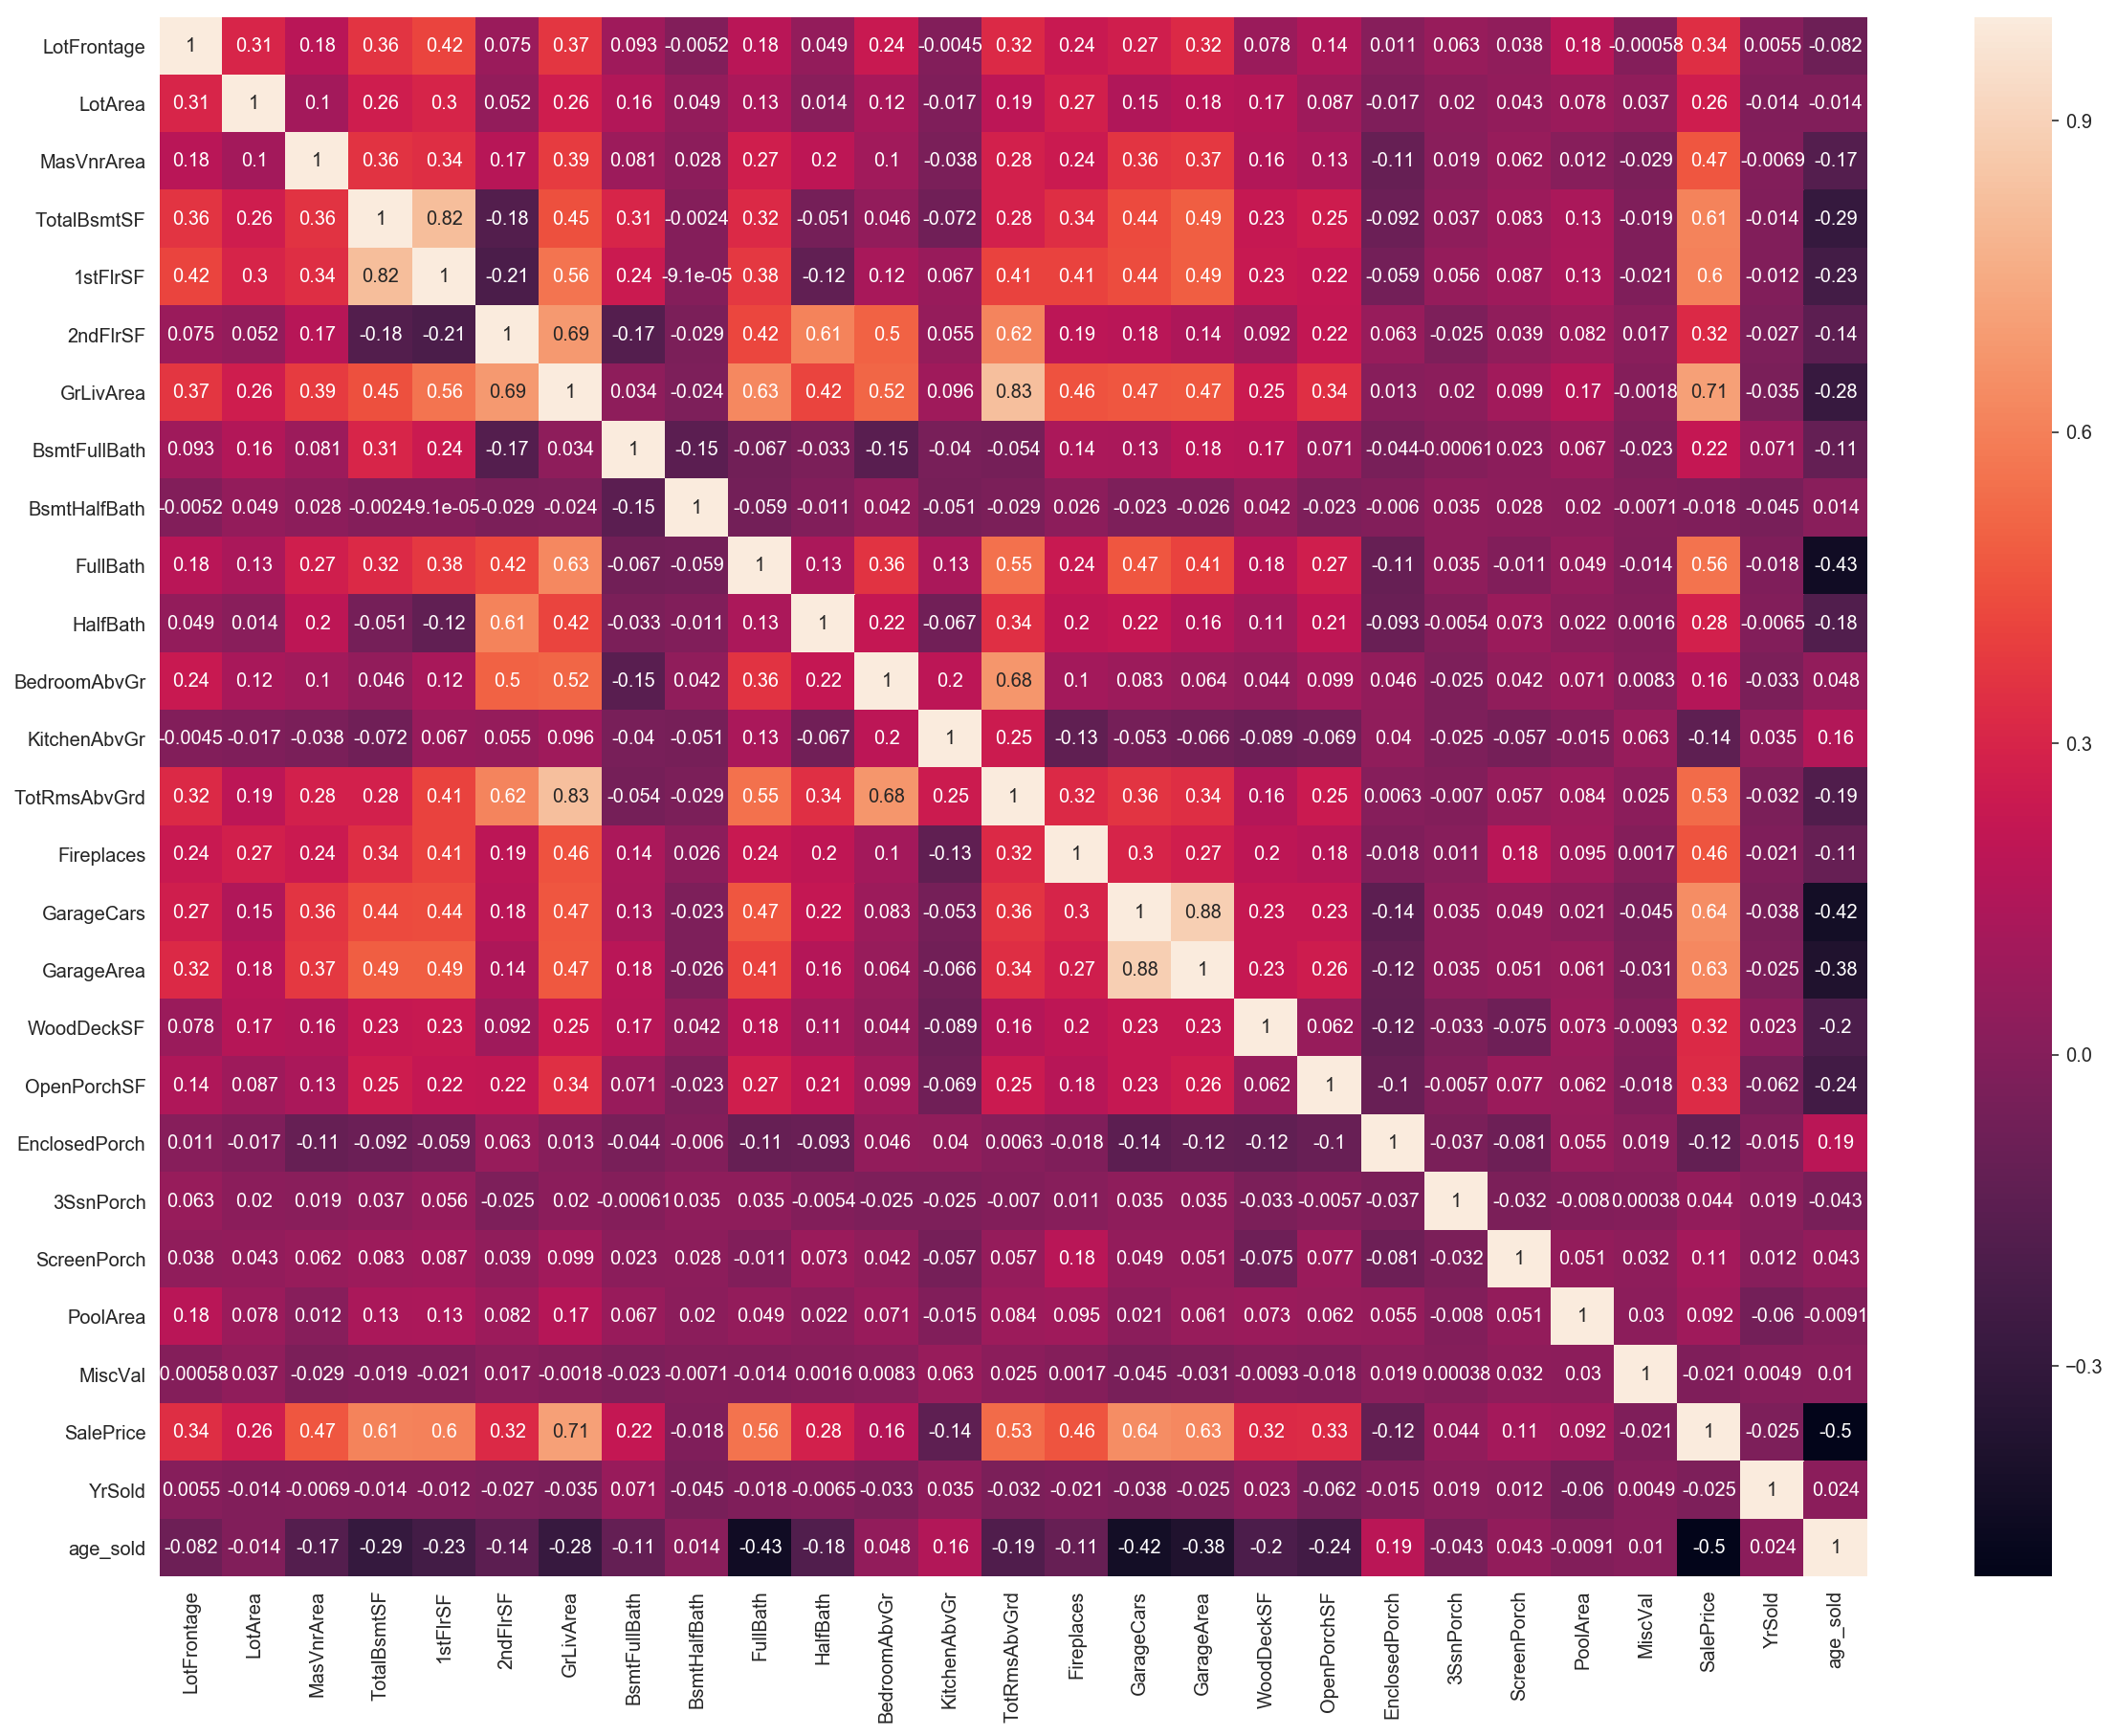

In [260]:
plt.figure(figsize=(20,15))
sns.heatmap(house_fixed.corr() , annot = True)

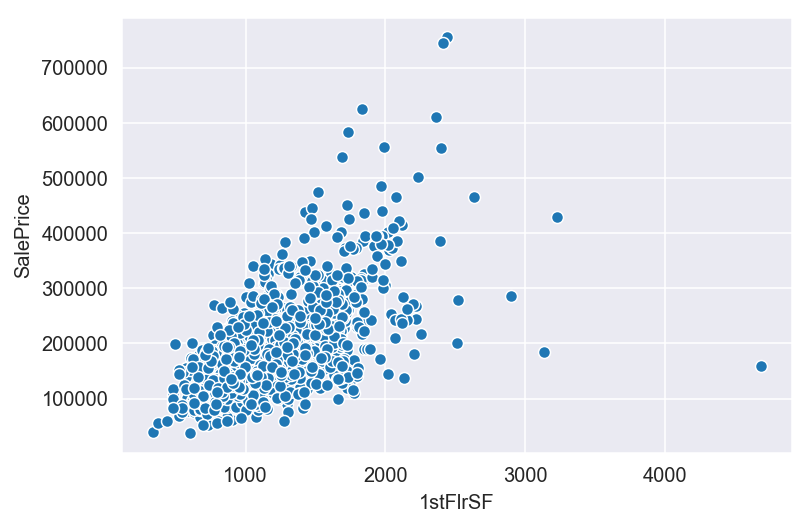

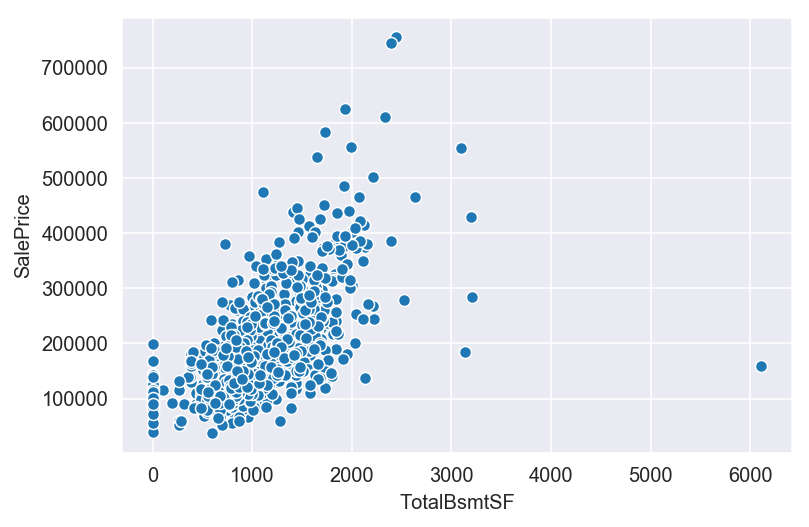

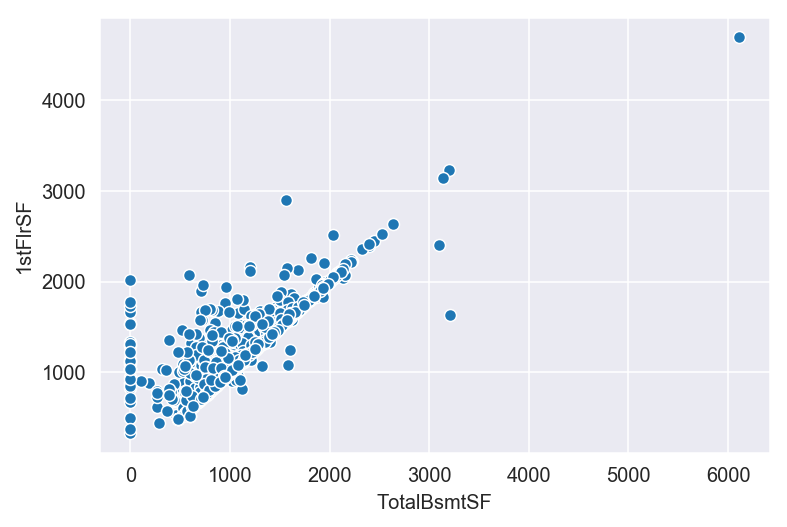

,1stFlrSF,TotalBsmtSF,SalePrice
1stFlrSF,1.000000,0.819138,0.603300
TotalBsmtSF,0.819138,1.000000,0.612088
SalePrice,0.603300,0.612088,1.000000


In [261]:
# look into 1stFlrSF + TotalBsmtSF as they are highly correlated : 0.82
sns.scatterplot(x = '1stFlrSF' , y = 'SalePrice' , data= house_fixed)
plt.show()

sns.scatterplot(x = 'TotalBsmtSF' , y = 'SalePrice' , data= house_fixed)
plt.show()

sns.scatterplot(x = 'TotalBsmtSF' , y = '1stFlrSF' , data= house_fixed)
plt.show()

house_fixed[['1stFlrSF','TotalBsmtSF','SalePrice']].corr()

In [262]:
#decided to drop 1stFlrSF as TotalBsmtSF has a higher correlation to price. 
house_fixed= house_fixed.drop(columns = '1stFlrSF')

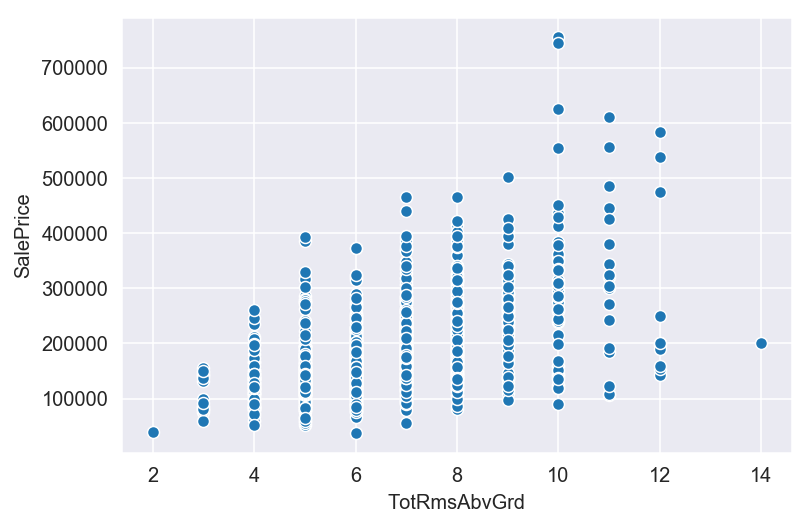

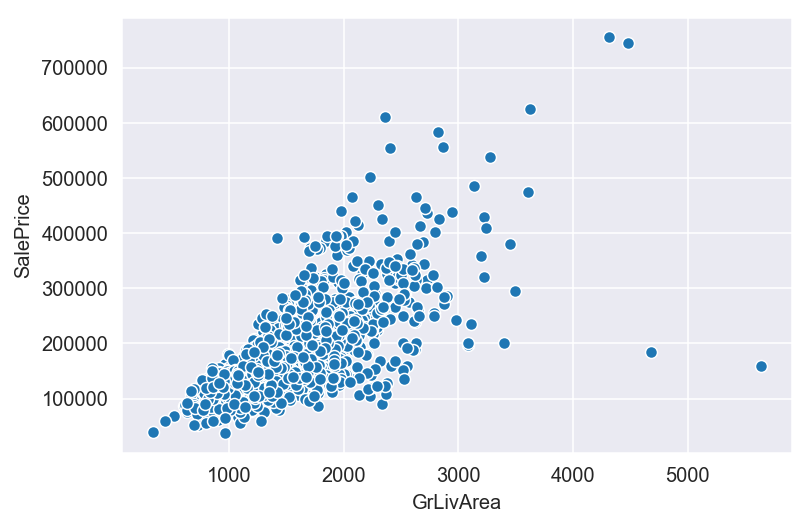

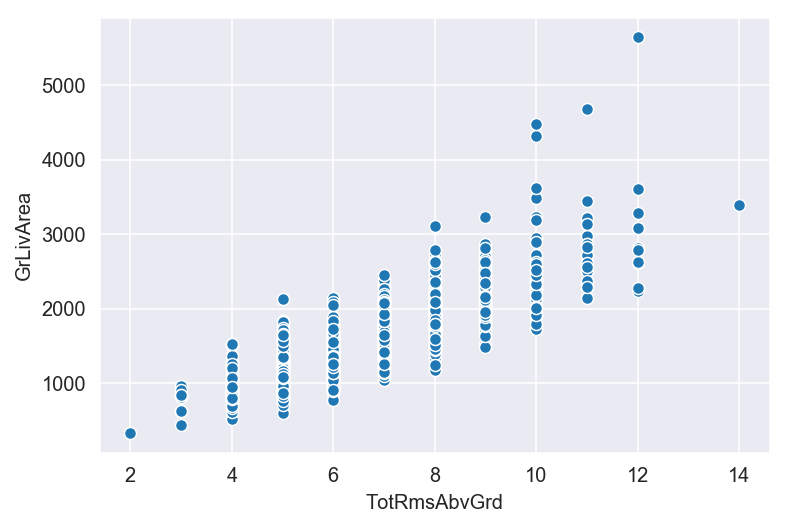

,TotRmsAbvGrd,GrLivArea,SalePrice
TotRmsAbvGrd,1.000000,0.825183,0.533355
GrLivArea,0.825183,1.000000,0.708658
SalePrice,0.533355,0.708658,1.000000


In [263]:
#look into GrLivArea + totalroomsabvgrd as they are highly correlated : 0.83 

sns.scatterplot(x = 'TotRmsAbvGrd' , y = 'SalePrice' , data= house_fixed)
plt.show()

sns.scatterplot(x = 'GrLivArea' , y = 'SalePrice' , data= house_fixed)
plt.show()

sns.scatterplot(x = 'TotRmsAbvGrd' , y = 'GrLivArea' , data= house_fixed)
plt.show()

house_fixed[['TotRmsAbvGrd','GrLivArea','SalePrice']].corr()

In [264]:
#decided to drop TotRmsAbvGrd as GrLivArea has higher correlation to SalePrice
house_fixed= house_fixed.drop(columns = 'TotRmsAbvGrd')

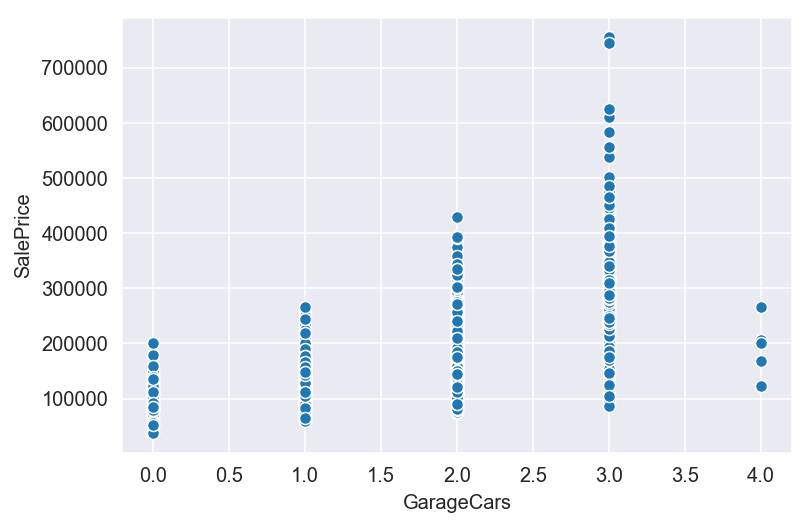

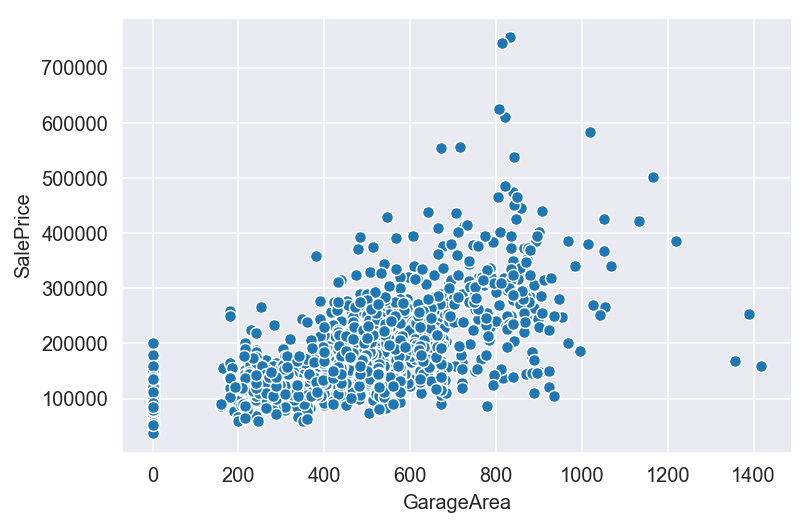

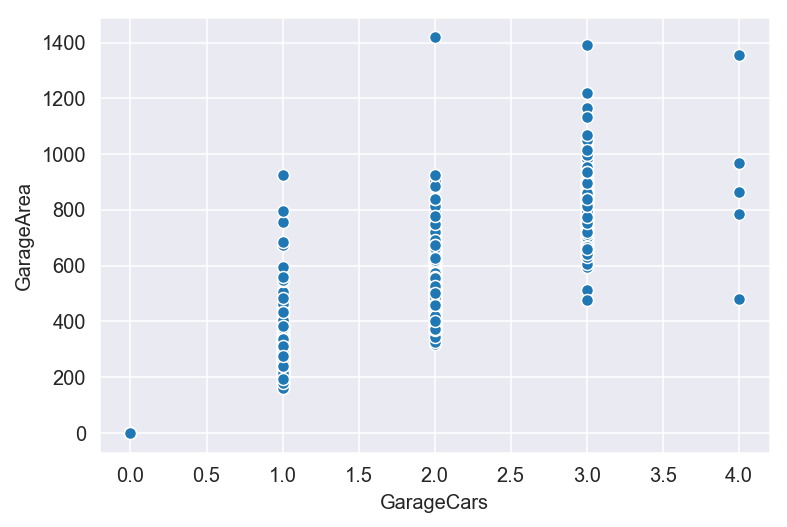

,GarageCars,GarageArea,SalePrice
GarageCars,1.000000,0.883009,0.642135
GarageArea,0.883009,1.000000,0.629831
SalePrice,0.642135,0.629831,1.000000


In [265]:
#look into GarageCars + GarageArea as they are highly correlated : 0.88

sns.scatterplot(x = 'GarageCars' , y = 'SalePrice' , data= house_fixed)
plt.show()

sns.scatterplot(x = 'GarageArea' , y = 'SalePrice' , data= house_fixed)
plt.show()

sns.scatterplot(x = 'GarageCars' , y = 'GarageArea' , data= house_fixed)
plt.show()

house_fixed[['GarageCars','GarageArea','SalePrice']].corr()

In [266]:
#decided to drop GarageArea as GarageCars has higher correlation to SalePrice
house_fixed= house_fixed.drop(columns = 'GarageArea')

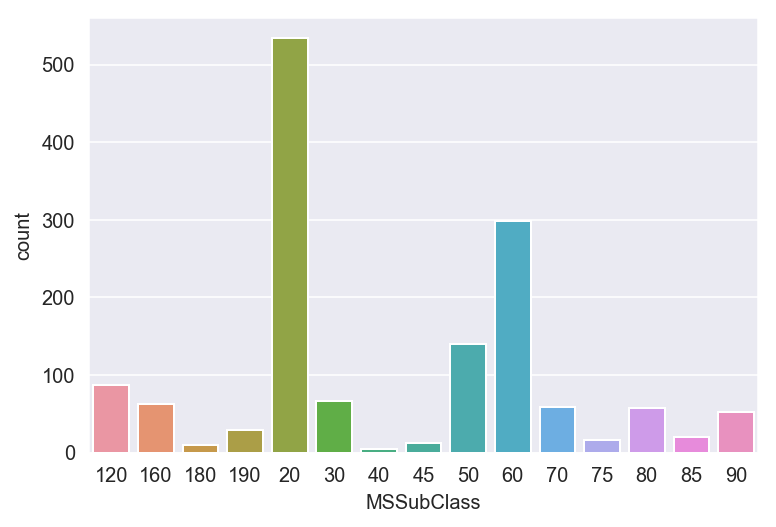

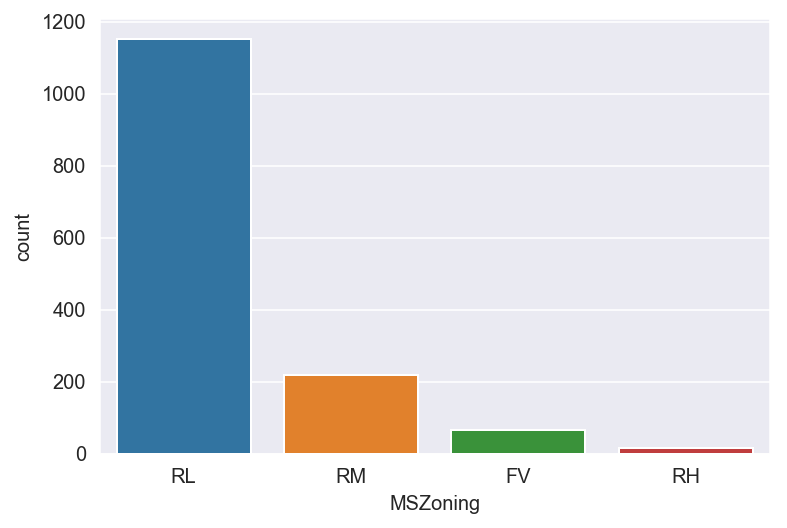

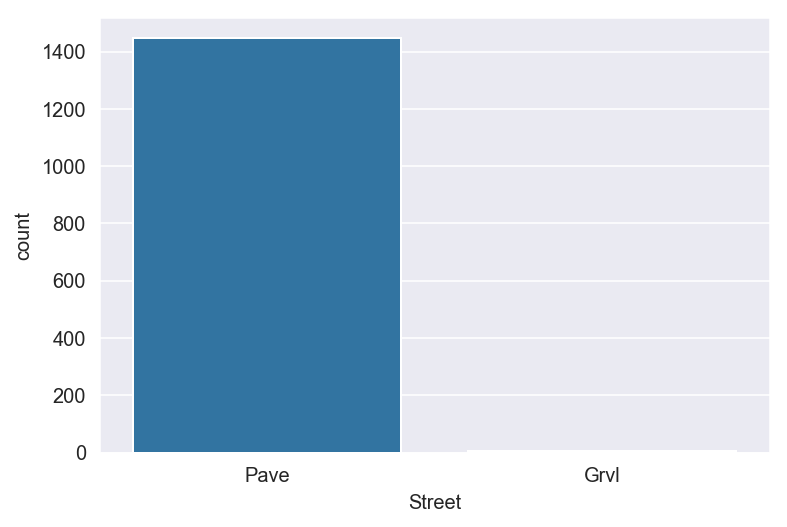

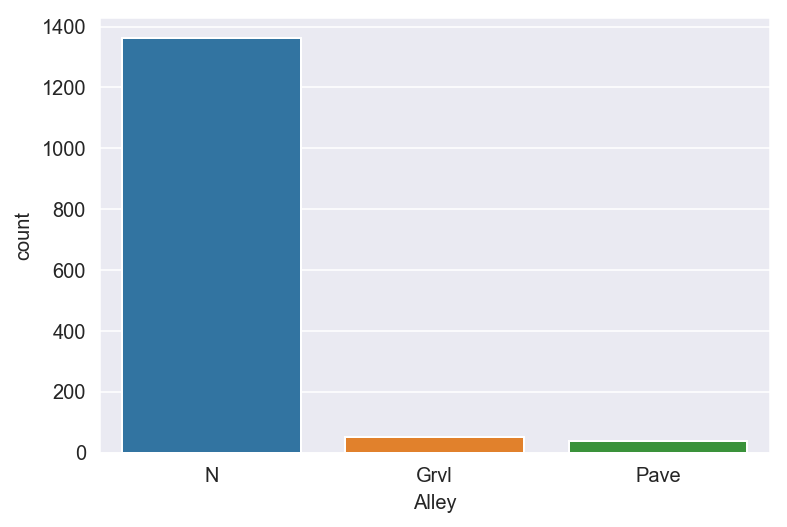

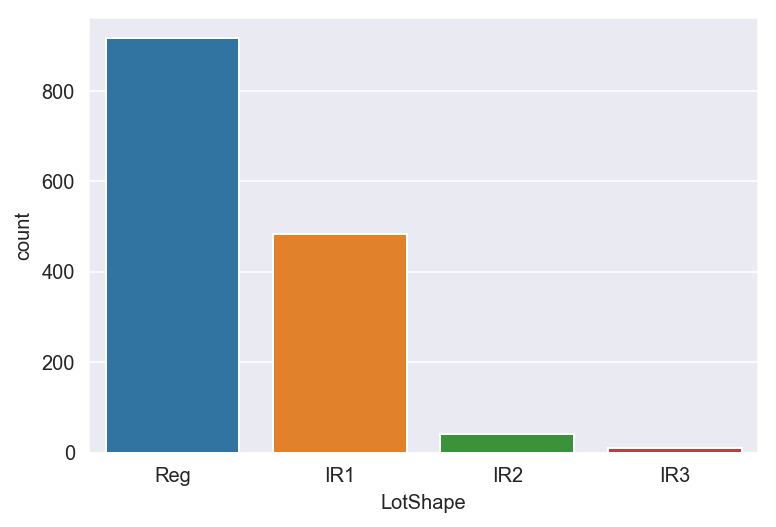

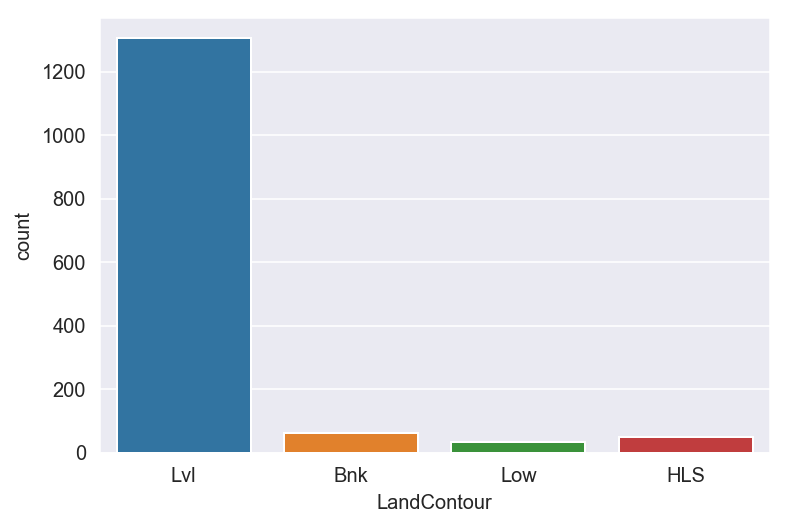

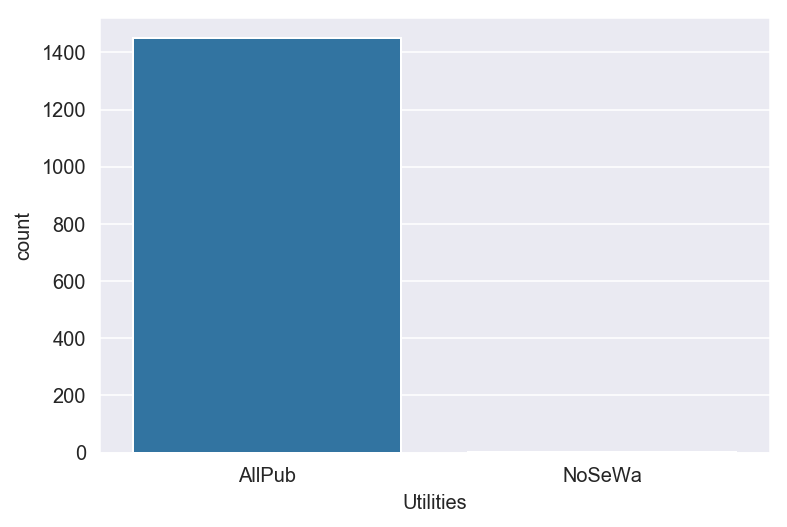

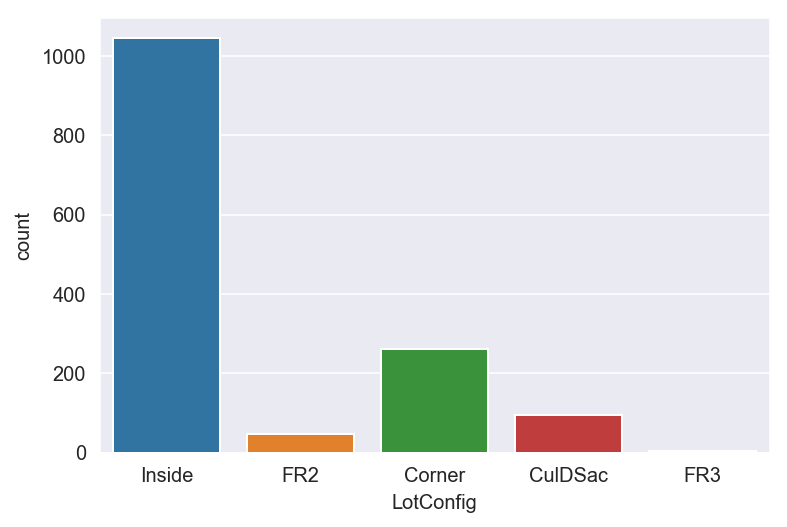

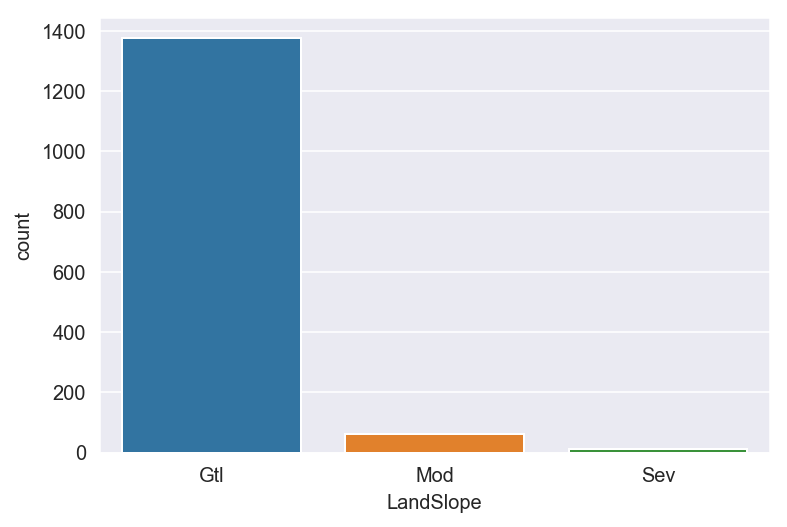

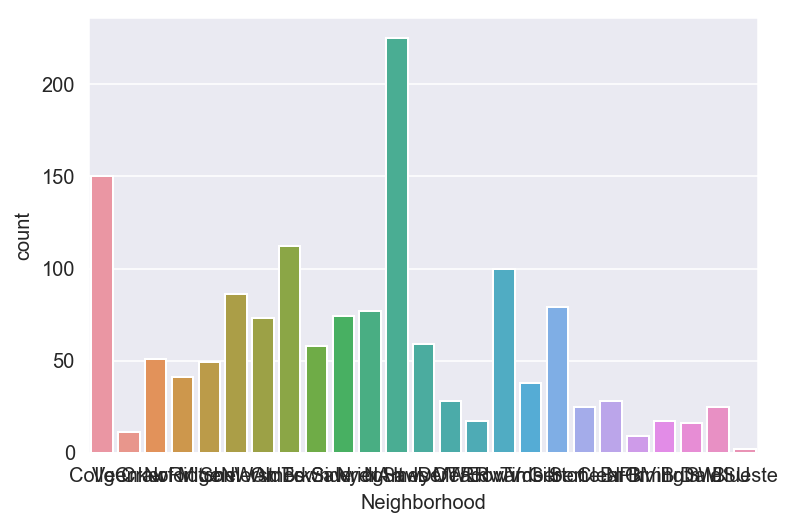

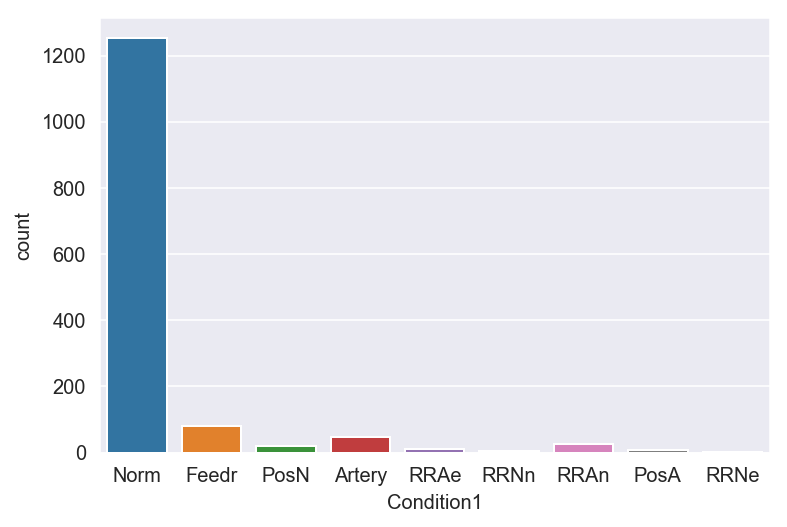

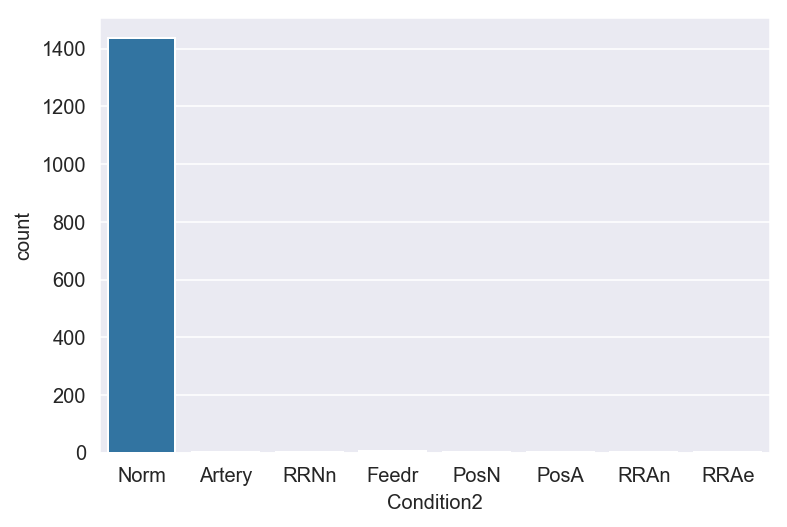

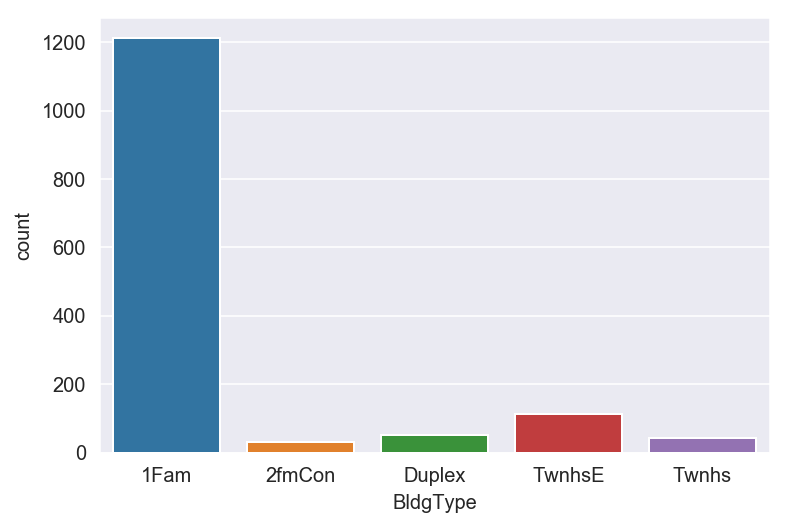

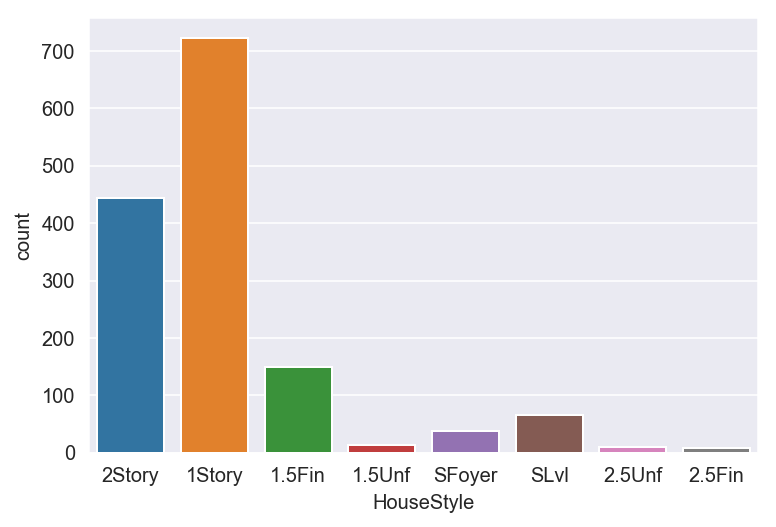

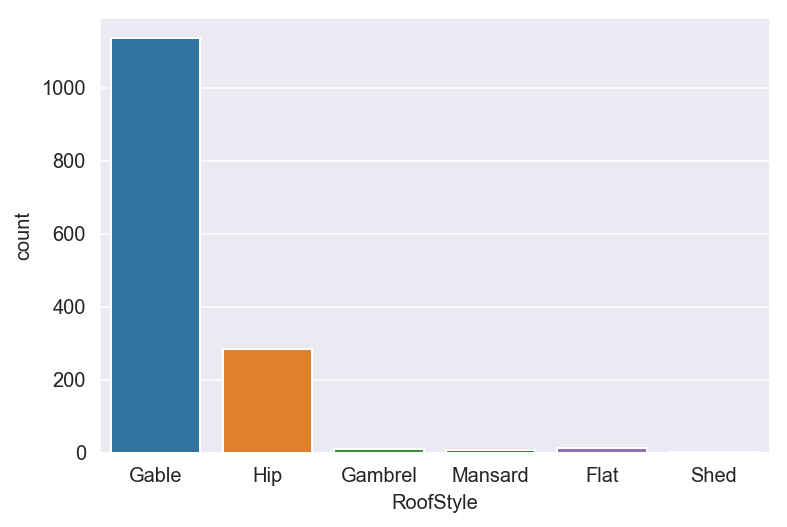

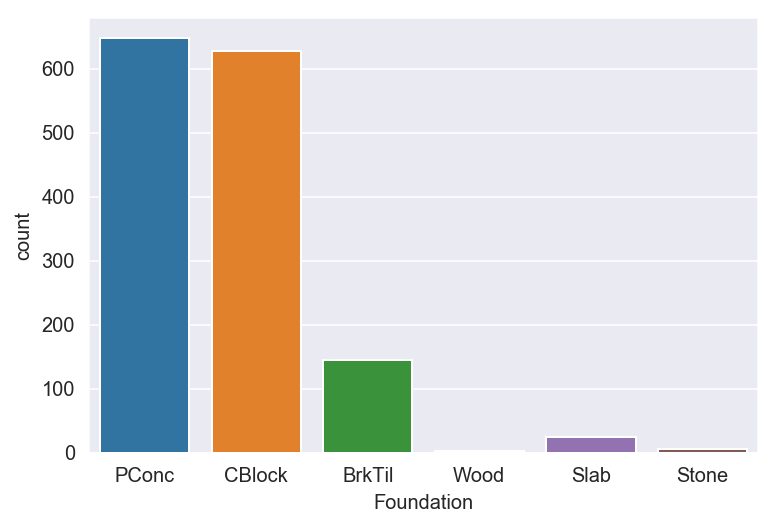

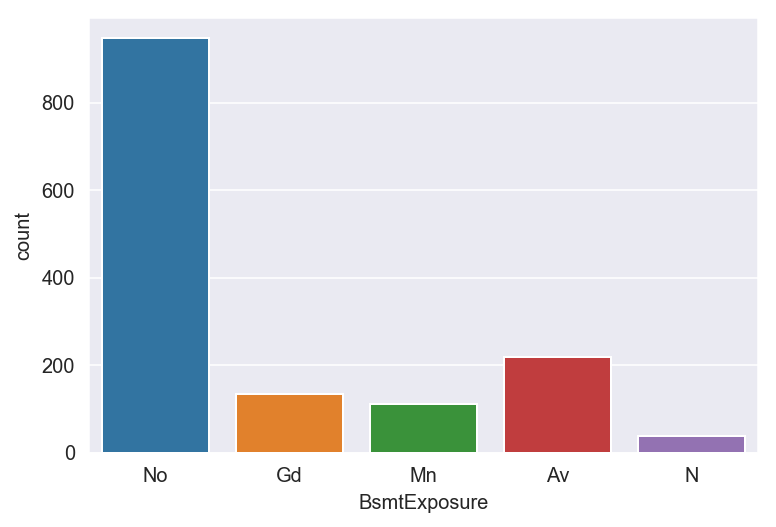

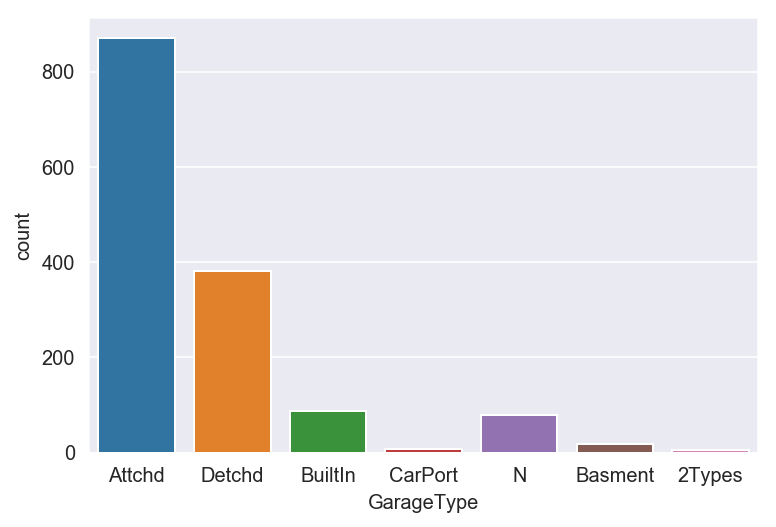

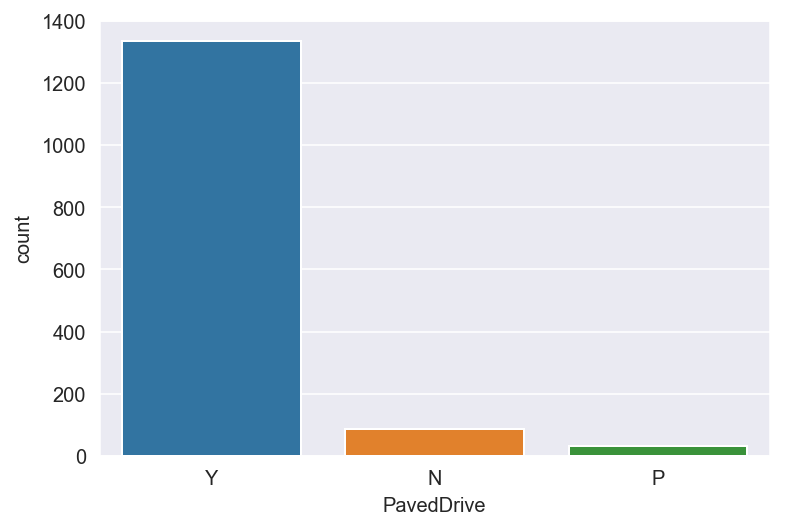

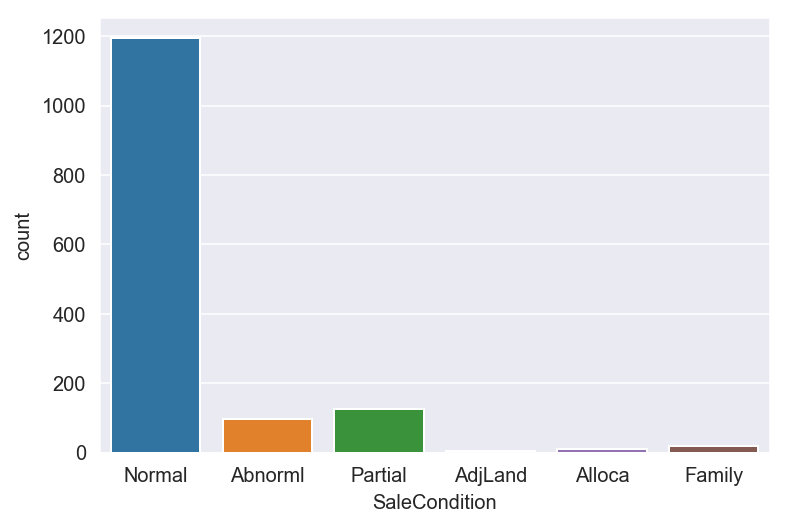

In [267]:
#analyse list of all object column
categorical = list(house_fixed.select_dtypes(include=['object']).columns)
for i in categorical:
    sns.countplot(house_fixed[i])
    plt.show()



In [268]:
#drop colums that only has one value (other values almost non-existence)
house_fixed = house_fixed.drop(columns =['Street' , 'Utilities' ,'Condition2'])

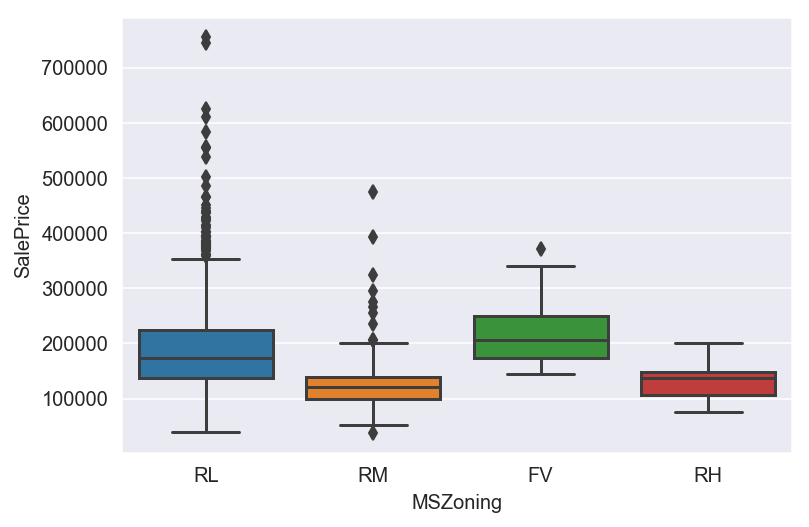

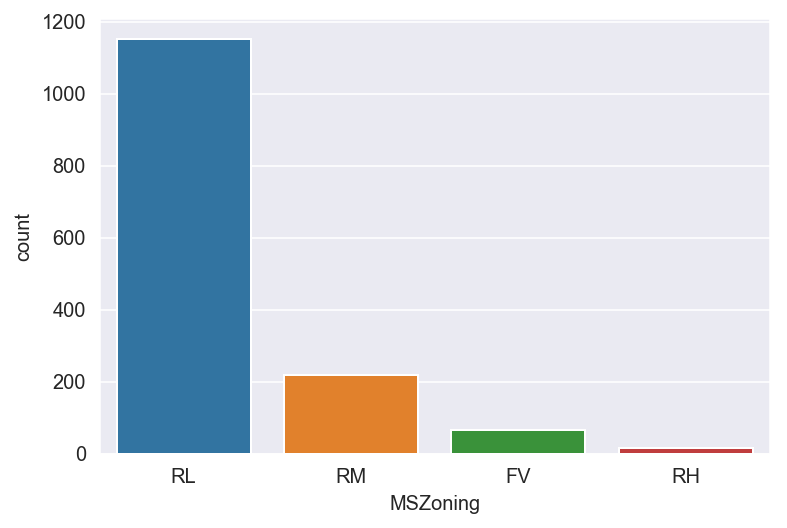

In [269]:
#analyse MSZoning
#Decided to merge RM and RH
sns.boxplot(x = 'MSZoning' , y =  'SalePrice' , data=house_fixed)
plt.show()
sns.countplot(x = 'MSZoning', data=house_fixed)
plt.show()


In [270]:
house_fixed['MSZoning'] = house_fixed['MSZoning'].map(lambda x : "Others" if x == "RM" or x == "RH" else x)

In [271]:
house_fixed['MSZoning'].value_counts()

RL        1151
Others     234
FV          65
Name: MSZoning, dtype: int64

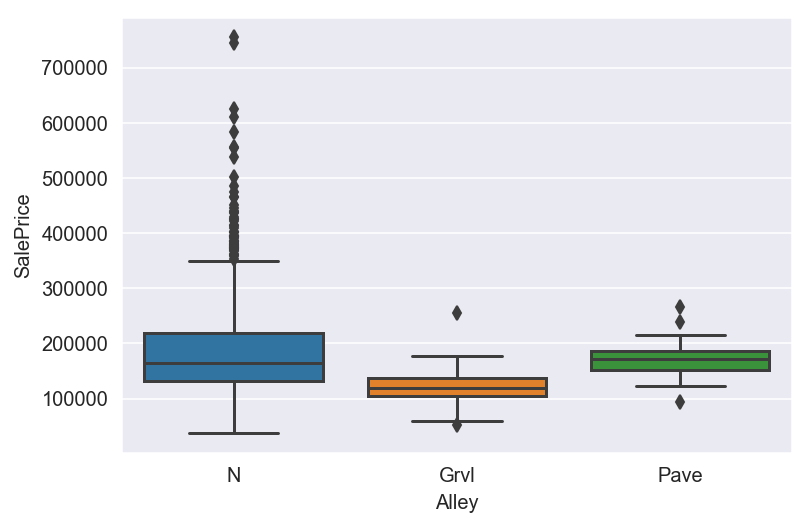

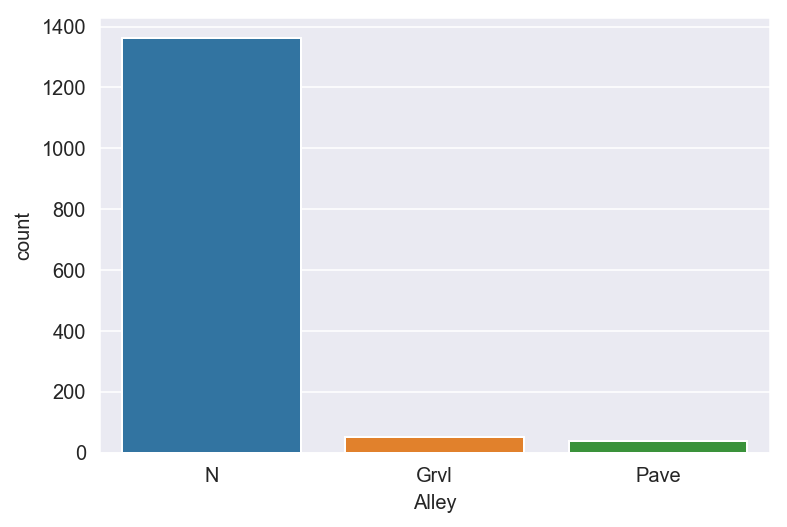

In [272]:
#Mean of the different category is different. Decided to leave it as it is. 
sns.boxplot(x = 'Alley' , y =  'SalePrice' , data=house_fixed)
plt.show()
sns.countplot(x = 'Alley', data=house_fixed)
plt.show()

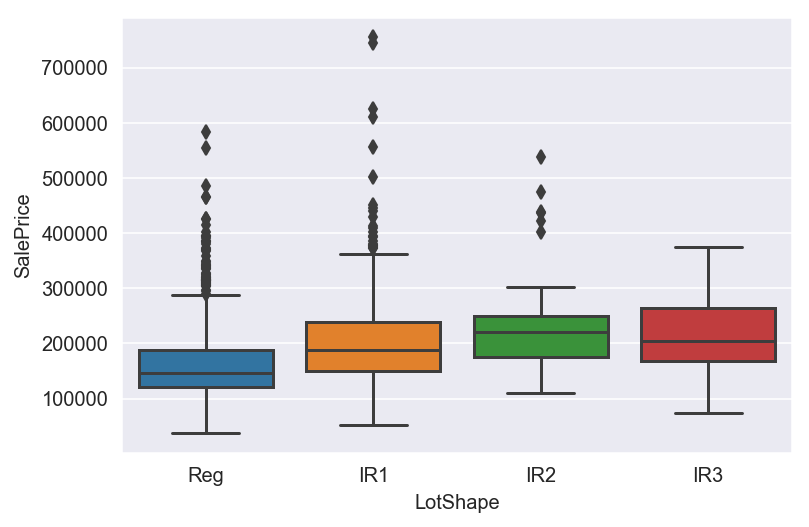

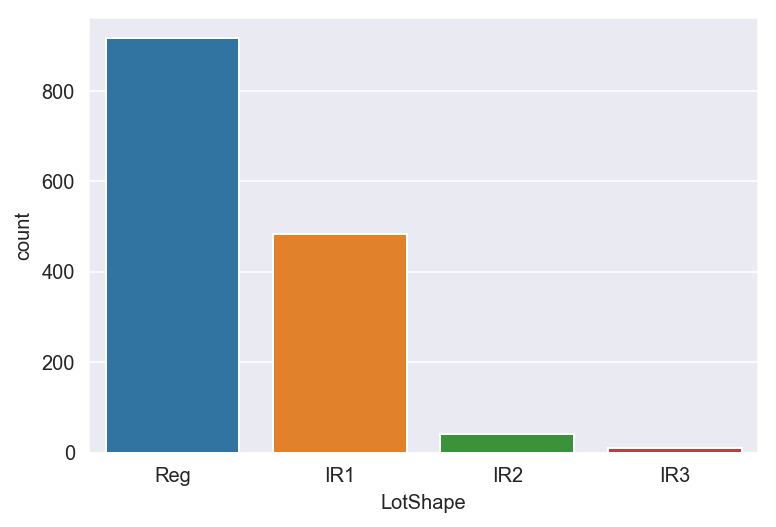

In [273]:
#The mean price is close. Decided to merge IR1, IR2 and IR3
sns.boxplot(x = 'LotShape' , y =  'SalePrice' , data=house_fixed)
plt.show()
sns.countplot(x = 'LotShape', data=house_fixed)
plt.show()

In [274]:
#Binarize LotShape : Reg / Others
house_fixed['LotShape'] = house_fixed['LotShape'].map(lambda x : x if x == "Reg" else "Others")
house_fixed['LotShape'].value_counts()

Reg       916
Others    534
Name: LotShape, dtype: int64

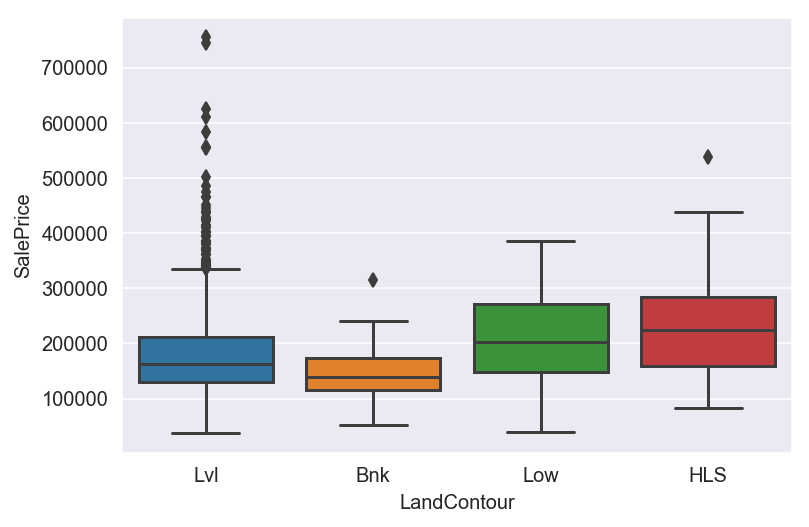

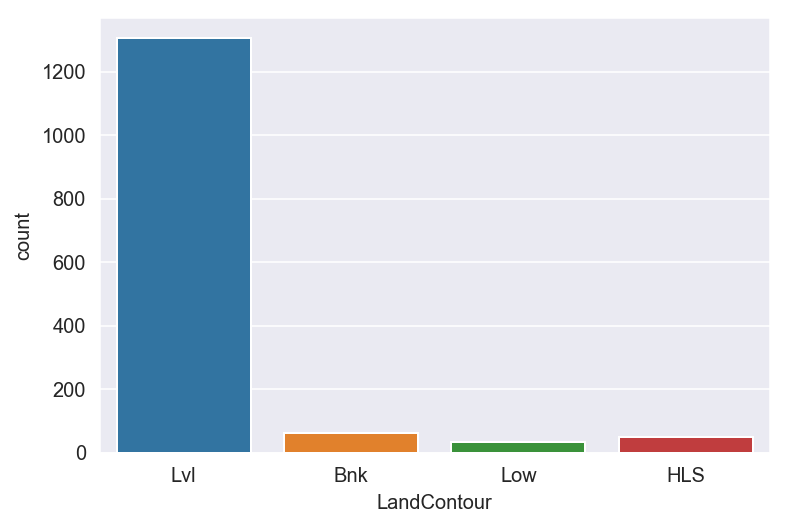

In [275]:
#check LandContour. Decided to merge Low and HLS

sns.boxplot(x = 'LandContour' , y =  'SalePrice' , data=house_fixed)
plt.show()
sns.countplot(x = 'LandContour', data=house_fixed)
plt.show()

In [276]:
house_fixed['LandContour'] = house_fixed['LandContour'].map(lambda x : "Others" if x == "Low" or x == "HLS" else x)
house_fixed['LandContour'].value_counts()

Lvl       1305
Others      83
Bnk         62
Name: LandContour, dtype: int64

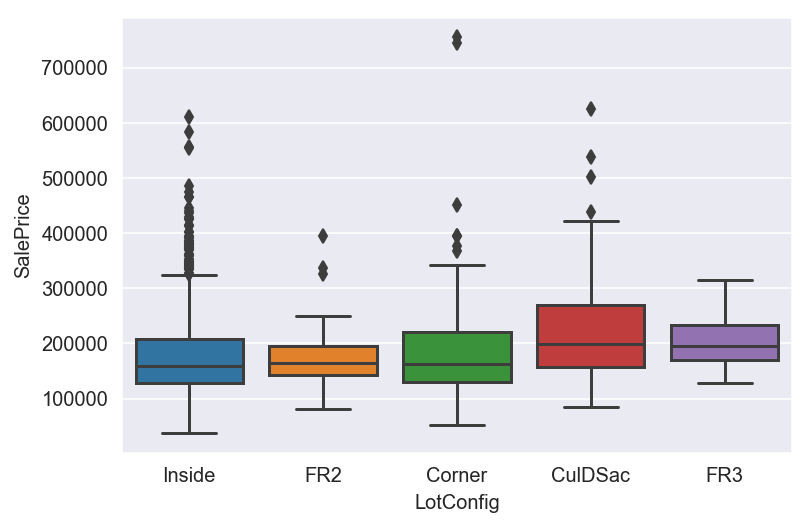

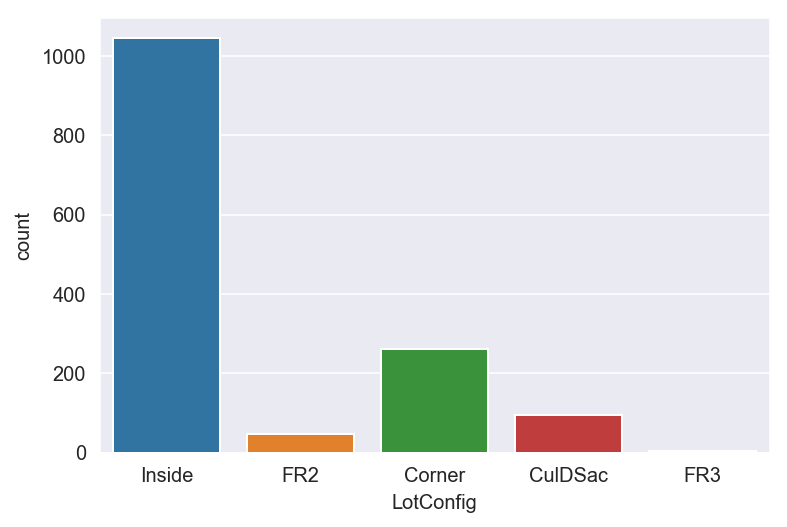

In [277]:
#check LotConfig. Decided merge FR2/Corner Lot Config , CulDSac/FR3
sns.boxplot(x = 'LotConfig' , y =  'SalePrice' , data=house_fixed)
plt.show()
sns.countplot(x = 'LotConfig', data=house_fixed)
plt.show()

In [278]:
#decided to merge FR2 , Corner Lotconfig , CulDSac and FR3
house_fixed['LotConfig'] = house_fixed['LotConfig'].map(
    lambda x :'Grp2' if x == "FR2" or x == "Corner" 
         else('Grp3' if x =="CulDSac" or x == "FR3" 
         else x)
)
house_fixed['LotConfig'].value_counts()

Inside    1044
Grp2       308
Grp3        98
Name: LotConfig, dtype: int64

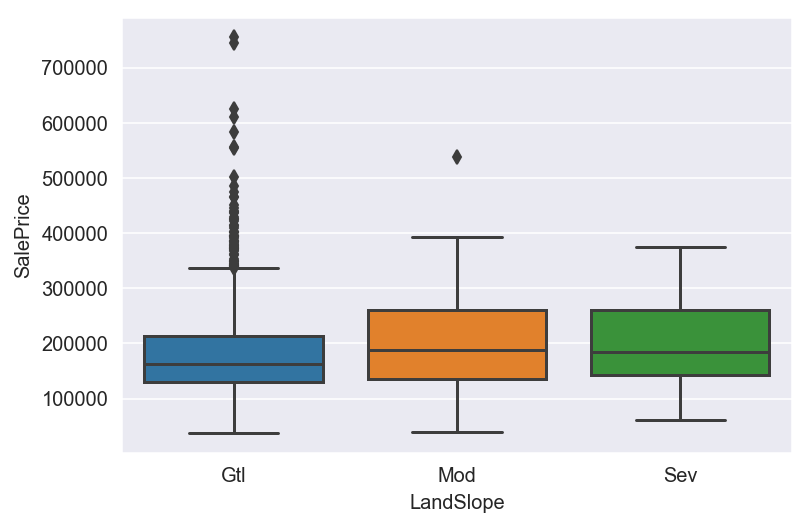

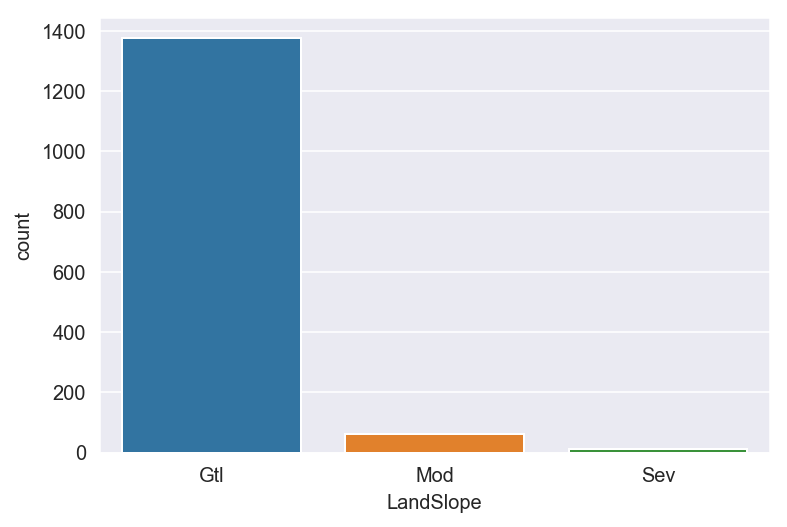

In [279]:
#Check LandSlope. Decided to binarize Landslope. Gtl = 1 , Mod/Sev = 0
sns.boxplot(x = 'LandSlope' , y =  'SalePrice' , data=house_fixed)
plt.show()
sns.countplot(x = 'LandSlope', data=house_fixed)
plt.show()

In [280]:
house_fixed['LandSlope'] = house_fixed['LandSlope'].map(lambda x : x if x == "Gtl" else "Others")
house_fixed['LandSlope'].value_counts()

Gtl       1375
Others      75
Name: LandSlope, dtype: int64

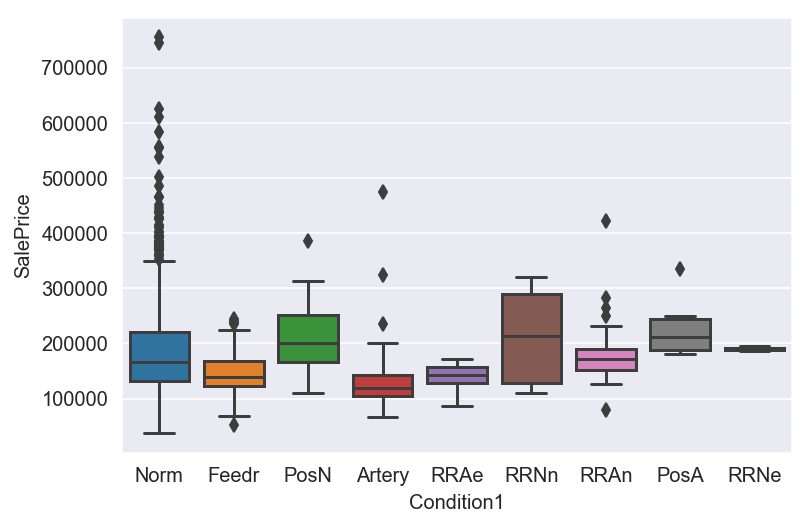

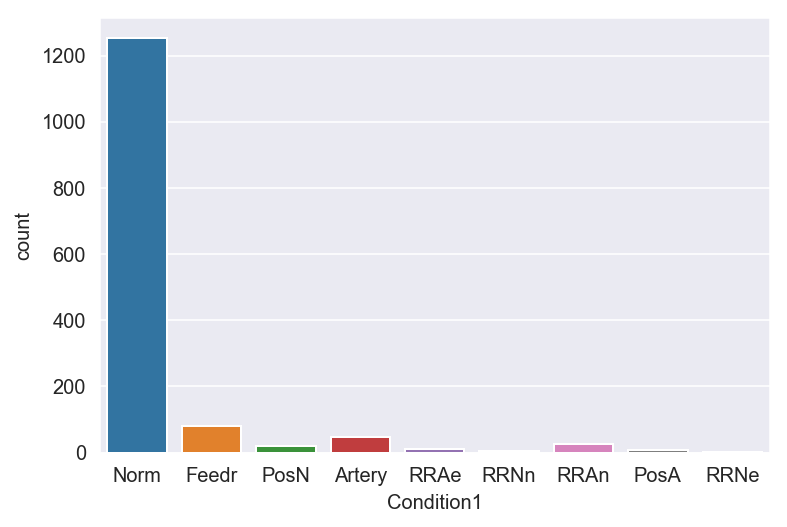

In [281]:
#Decided not to change. 
sns.boxplot(x = 'Condition1' , y =  'SalePrice' , data=house_fixed)
plt.show()
sns.countplot(x = 'Condition1', data=house_fixed)
plt.show()

In [282]:
house_fixed.Condition1.value_counts()

Norm      1252
Feedr       79
Artery      48
RRAn        26
PosN        19
RRAe        11
PosA         8
RRNn         5
RRNe         2
Name: Condition1, dtype: int64

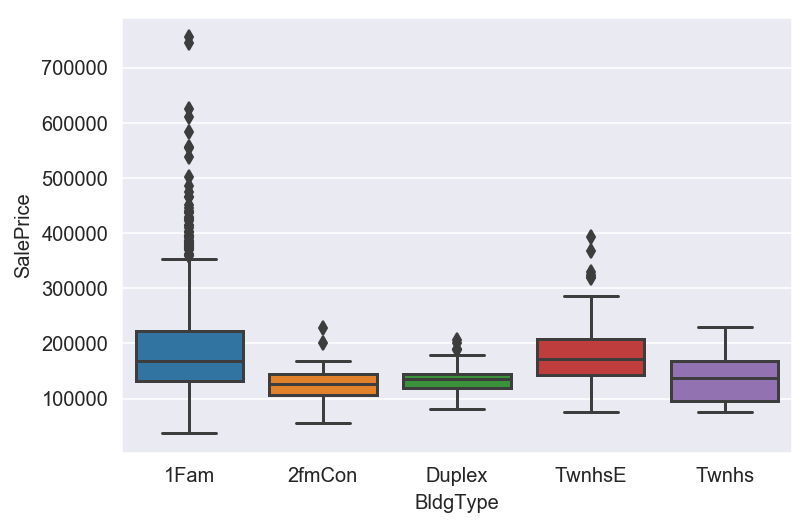

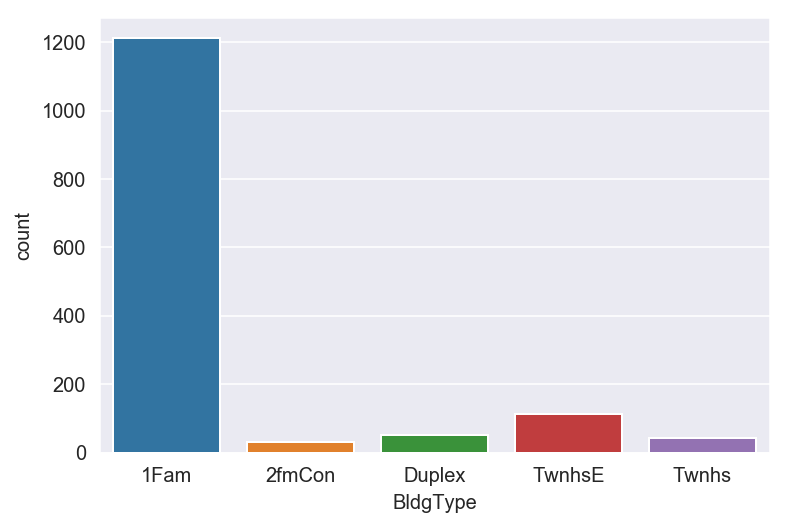

In [283]:
#Check BldgType. Decided to merge 2fmCon , Duplex , Twnhs
sns.boxplot(x = 'BldgType' , y =  'SalePrice' , data=house_fixed)
plt.show()
sns.countplot(x = 'BldgType', data=house_fixed)
plt.show()

In [284]:
house_fixed['BldgType'] = house_fixed['BldgType'].map(
    lambda x :'Others' if x == "2fmCon" or x == "Duplex" or x == 'Twnhs' else x)
house_fixed['BldgType'].value_counts()

1Fam      1211
Others     125
TwnhsE     114
Name: BldgType, dtype: int64

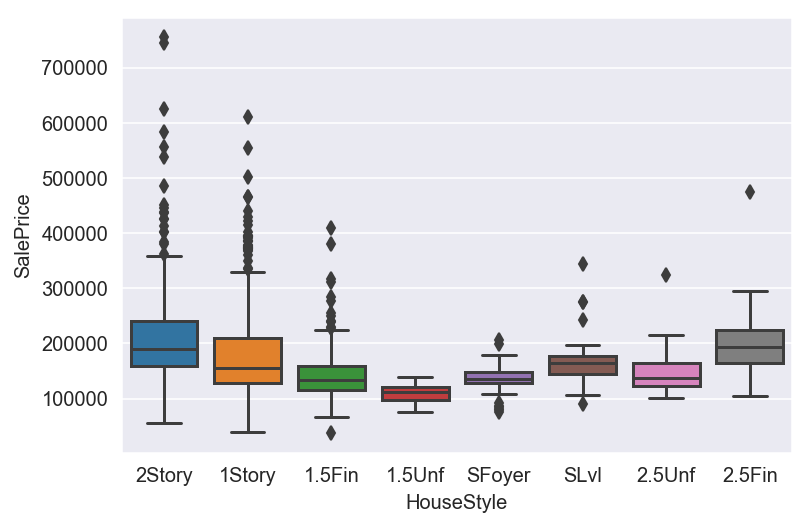

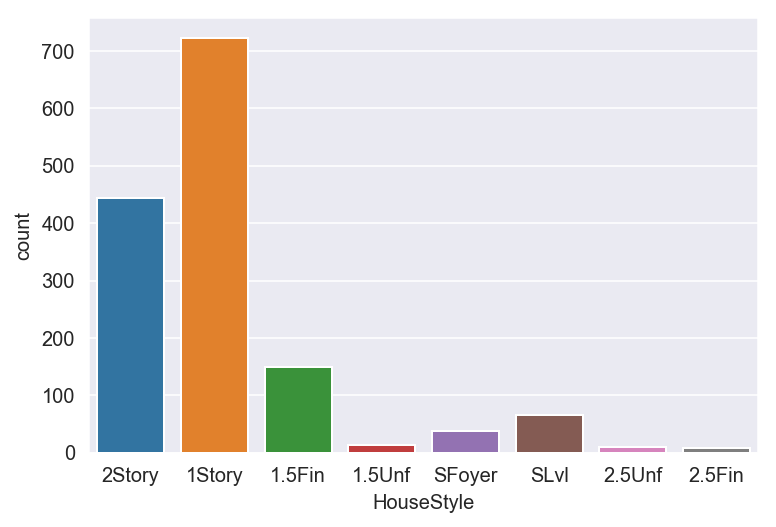

In [285]:
#check HouseStyle. Decided not to change
sns.boxplot(x = 'HouseStyle' , y =  'SalePrice' , data=house_fixed)
plt.show()
sns.countplot(x = 'HouseStyle', data=house_fixed)
plt.show()

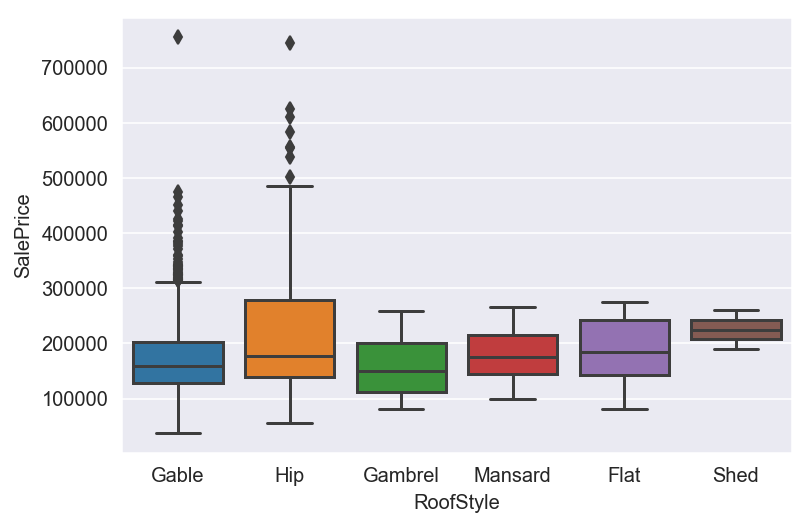

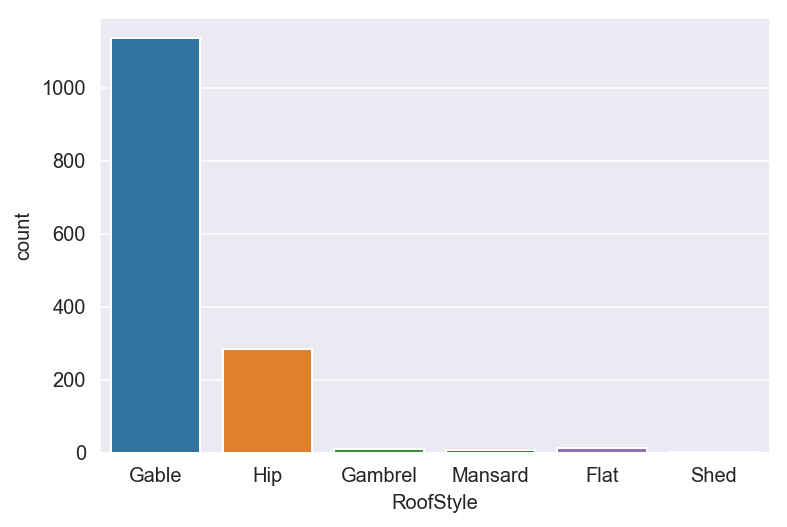

In [286]:
#check Roofstyle
sns.boxplot(x = 'RoofStyle' , y =  'SalePrice' , data=house_fixed)
plt.show()
sns.countplot(x = 'RoofStyle', data=house_fixed)
plt.show()

In [287]:
house_fixed['RoofStyle'].value_counts()

Gable      1135
Hip         283
Flat         13
Gambrel      10
Mansard       7
Shed          2
Name: RoofStyle, dtype: int64

In [288]:
#decided to keep Gable and merge the rest. 
house_fixed['RoofStyle'] = house_fixed['RoofStyle'].map(lambda x :x if x == "Gable" else "Others")
house_fixed['RoofStyle'].value_counts()

Gable     1135
Others     315
Name: RoofStyle, dtype: int64

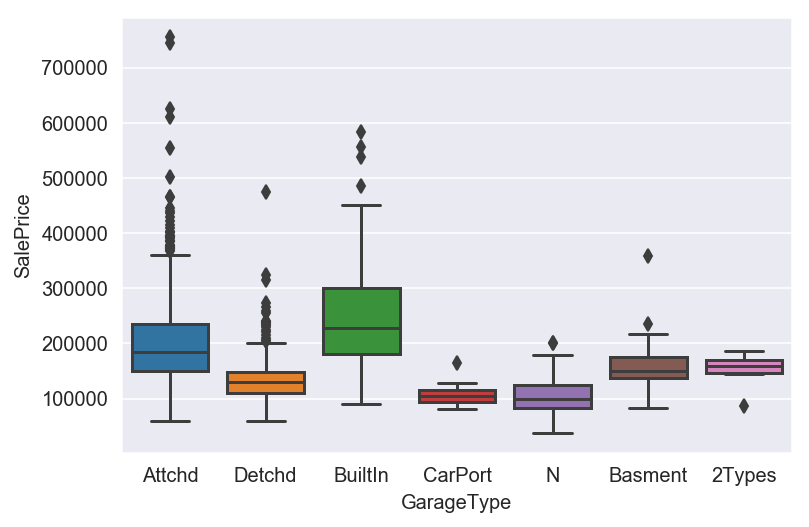

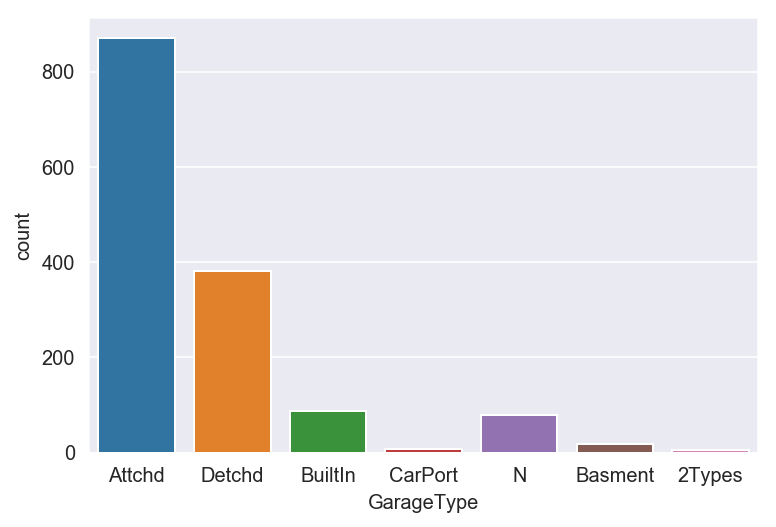

In [289]:
#check GarageType. Decided to group them into Attchd,Builtin and Others 
sns.boxplot(x = 'GarageType' , y =  'SalePrice' , data=house_fixed)
plt.show()
sns.countplot(x = 'GarageType', data=house_fixed)
plt.show()

In [290]:
house_fixed['GarageType'] = house_fixed['GarageType'].map(lambda x :x if x == "Builtin" or x == "Attchd" 
                                                          else "Others")
house_fixed['GarageType'].value_counts()

Attchd    870
Others    580
Name: GarageType, dtype: int64

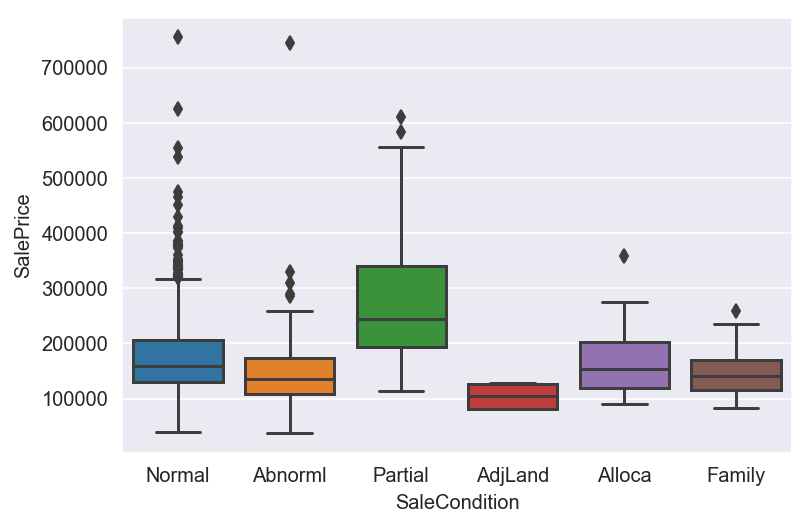

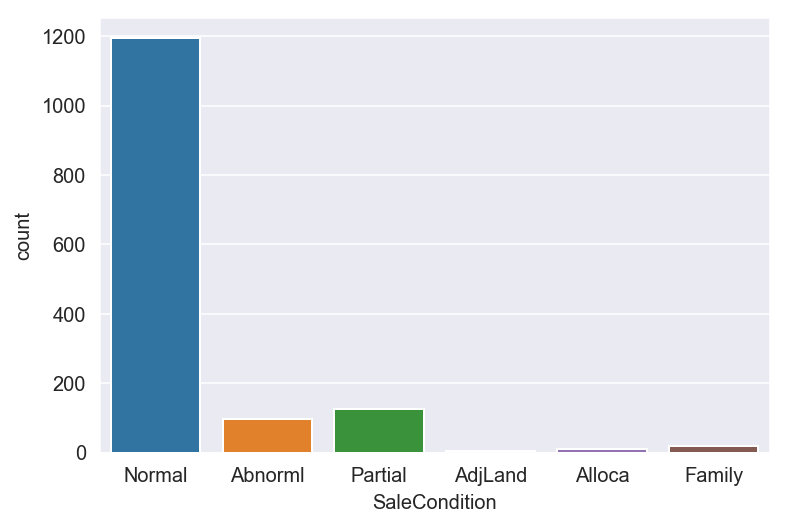

Normal     1194
Partial     125
Abnorml      96
Family       20
Alloca       11
AdjLand       4
Name: SaleCondition, dtype: int64

In [291]:
#Check SaleCondition
sns.boxplot(x = 'SaleCondition' , y =  'SalePrice' , data=house_fixed)
plt.show()
sns.countplot(x = 'SaleCondition', data=house_fixed)
plt.show()

house_fixed.SaleCondition.value_counts()

In [292]:
house_fixed['SaleCondition'] = house_fixed['SaleCondition'].map(lambda x :x if x == "Normal" or x == "Partial" 
                                                          else "Others")
house_fixed['SaleCondition'].value_counts()

Normal     1194
Others      131
Partial     125
Name: SaleCondition, dtype: int64

In [293]:
len(house_fixed.columns)

41

In [294]:
house_fixed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 41 columns):
MSSubClass       1450 non-null object
MSZoning         1450 non-null object
LotFrontage      1450 non-null float64
LotArea          1450 non-null int64
Alley            1450 non-null object
LotShape         1450 non-null object
LandContour      1450 non-null object
LotConfig        1450 non-null object
LandSlope        1450 non-null object
Neighborhood     1450 non-null object
Condition1       1450 non-null object
BldgType         1450 non-null object
HouseStyle       1450 non-null object
RoofStyle        1450 non-null object
MasVnrArea       1450 non-null float64
Foundation       1450 non-null object
BsmtExposure     1450 non-null object
TotalBsmtSF      1450 non-null int64
2ndFlrSF         1450 non-null int64
GrLivArea        1450 non-null int64
BsmtFullBath     1450 non-null int64
BsmtHalfBath     1450 non-null int64
FullBath         1450 non-null int64
HalfBath         1450 no

In [295]:
#apply get_dummies
categorical = list(house_fixed.select_dtypes(include=['object']).columns)
df_dummies = pd.get_dummies(house_fixed[categorical], drop_first=True)

In [296]:
house_fixed= house_fixed.drop(columns = categorical)

In [297]:
house_fixed = pd.concat([house_fixed, df_dummies], axis=1)

In [298]:
len(house_fixed.columns)

104

In [299]:
#split data into 2010(test data) and before 2010(training data)
house_fixed_2010 = house_fixed[house_fixed['YrSold'] == 2010]
y_test = house_fixed_2010[['SalePrice']]
X_test = house_fixed_2010.drop(columns = 'SalePrice')

house_fixed_training = house_fixed[house_fixed['YrSold'] < 2010]
y_train = house_fixed_training[['SalePrice']]
X_train = house_fixed_training.drop(columns = 'SalePrice')

In [300]:
#perform automatic feature selection method "SelectKBest"
from sklearn.feature_selection import SelectKBest,f_regression
cols = list(X_train.columns)
# Build the selector — we'll build one with each score type.
skb_f = SelectKBest(f_regression)

# Train the selector on the data.
skb_f.fit(X_train, y_train)

# Examine the results.
kbest = pd.DataFrame([cols, list(skb_f.scores_),list(skb_f.pvalues_)], 
                     index=['feature','f_regression','p_values']).T.sort_values\
                     ('f_regression', ascending=False)

#select only variables with p-value lower than 0.05
significant = kbest[kbest['p_values']<0.05]
print(significant.shape)
significant

(71, 3)


c:\users\chenz\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,feature,f_regression,p_values
5,GrLivArea,1284,3.75489e-195
13,GarageCars,894.937,1.96186e-149
3,TotalBsmtSF,731.737,9.40283e-128
8,FullBath,590.937,1.41251e-107
22,age_sold,443.142,1.11217e-84
90,Foundation_PConc,387.207,1.71151e-75
12,Fireplaces,358.346,1.24868e-70
2,MasVnrArea,353.786,7.46263e-70
62,Neighborhood_NridgHt,255.633,1.38069e-52
31,MSSubClass_60,221.62,2.44548e-46


In [301]:
#Select range of features by 10 by f_regression score
top_list=[]
for i in range(10,90,10):
    top =[]
    top = list(significant.feature.head(i))
    top_list.append(top)

In [302]:
#Apply linear regression model on the features selected by using kbest_f_regression
#Run through different number of features. 
for ls in top_list:
    print("===",len(ls), "Features===")
#     Xs = ss.fit_transform(X_train[ls])
#     Xs_test = ss.transform(X_test[ls])
    X_ = X_train[ls]
    X_test_ = X_test[ls]
    model = LinearRegression()
    # Perform cross-validation
    scores = cross_val_score(model,X_, y_train, cv=10)
    print("Cross-validated scores:", scores)
    print("Mean CV R2:", np.mean(scores))
    print('Std CV R2:', np.std(scores))

    model.fit(X_,y_train)

    print("Test Score:" ,model.score(X_test_,y_test))
    print("")

=== 10 Features===
Cross-validated scores: [0.78234934 0.81160027 0.83572281 0.70820872 0.74963205 0.82212446
 0.79301186 0.73779453 0.43250456 0.79490364]
Mean CV R2: 0.7467852243594363
Std CV R2: 0.11128943981405665
Test Score: 0.7953860676269622

=== 20 Features===
Cross-validated scores: [0.8298307  0.80934872 0.82428699 0.72839422 0.79567236 0.84525411
 0.80143875 0.74147154 0.49096642 0.8238004 ]
Mean CV R2: 0.7690464198541255
Std CV R2: 0.09933569328729615
Test Score: 0.804897020985312

=== 30 Features===
Cross-validated scores: [0.84112948 0.81153931 0.83550413 0.74192412 0.78957966 0.83716969
 0.82269934 0.73903438 0.50515702 0.84808195]
Mean CV R2: 0.7771819084584006
Std CV R2: 0.09809076504088907
Test Score: 0.8181399000640717

=== 40 Features===
Cross-validated scores: [0.86524385 0.84659886 0.85843835 0.76510132 0.8037174  0.82373921
 0.8504207  0.77783002 0.52932518 0.84526155]
Mean CV R2: 0.7965676440629144
Std CV R2: 0.09479870807405633
Test Score: 0.8414598456830986

=

Achieved the best score when 71 features use being applied. 

Linear Regression ( No standard Scaler ) 

=== 71 Features===

Cross-validated scores: [0.88108405 0.86068164 0.84961026 0.76723482 0.80291849 0.83717526
 0.85956377 0.79780021 0.5629125  0.84600284]
 
Mean CV R2: 0.8064983840114938

Std CV R2: 0.08754385933589093

Test Score: 0.8531315081956997

Next step

Try to scale features to see if its possible to get a better result.

In [303]:
#Apply linear regression model on 71 features. Apply Standard Scaler
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

print("===",len(top_list[-1]), "Features===")
Xs_train = ss.fit_transform(X_train[top_list[-1]])
Xs_test = ss.transform(X_test[top_list[-1]])
model = LinearRegression()
# Perform cross-validation
scores = cross_val_score(model,Xs_train, y_train, cv=10)
print("Cross-validated scores:", scores)
print("Mean CV R2:", np.mean(scores))
print('Std CV R2:', np.std(scores))

model.fit(Xs_train,y_train)

print("Test Score:" ,model.score(Xs_test,y_test))
print("")

=== 71 Features===
Cross-validated scores: [0.88108405 0.86068164 0.84961026 0.76723482 0.80291849 0.83717526
 0.85956377 0.79780021 0.5629125  0.84600284]
Mean CV R2: 0.8064983840114965
Std CV R2: 0.08754385933583743
Test Score: 0.8531315081956128



After scaling , the score is still similar. 

Next step , try fitting into LassoCv to see if we could reduce the number of variables further or get a better score

In [304]:
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV, Lasso
#find optimal alpha from lassocv
optimal_lasso = LassoCV(n_alphas=500, cv=10)
optimal_lasso.fit(Xs_train, y_train)
print(optimal_lasso.alpha_)

c:\users\chenz\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


755.7929415281102


In [305]:
house['SalePrice'].shape

(1450,)

In [306]:
lasso = Lasso(alpha=optimal_lasso.alpha_)
lasso_scores = cross_val_score(lasso, Xs_train, y_train, cv=10)
lasso.fit(Xs_train,y_train)
lasso.score(Xs_test,y_test)

print("===Lasso(71 Features)===")
print("Cross-validated scores:", lasso_scores)
print("Mean CV R2:", np.mean(lasso_scores))
print('Std CV R2:', np.std(lasso_scores))
print("Test Score:" ,lasso.score(Xs_test,y_test))

lasso_coefs = pd.DataFrame({'variable':X_train[top_list[-1]].columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})


print(lasso_coefs[lasso_coefs['coef'] !=0].shape)

lasso_coefs[lasso_coefs['coef'] !=0].sort_values(by ='abs_coef',ascending=False).head(10)

===Lasso(71 Features)===
Cross-validated scores: [0.87706329 0.8573267  0.86041652 0.77157796 0.80270869 0.8522795
 0.86561066 0.80378712 0.56730404 0.85682917]
Mean CV R2: 0.8114903646980013
Std CV R2: 0.08763522890173395
Test Score: 0.8523442210524417
(50, 3)


,abs_coef,coef,variable
0,28837.485003,28837.485003,GrLivArea
8,13842.166010,13842.166010,Neighborhood_NridgHt
12,9735.163415,9735.163415,Neighborhood_NoRidge
1,9351.266962,9351.266962,GarageCars
30,7940.738052,7940.738052,Neighborhood_StoneBr
4,7542.197733,-7542.197733,age_sold
39,6348.457300,6348.457300,Neighborhood_Somerst
2,5983.079474,5983.079474,TotalBsmtSF
18,5586.044338,5586.044338,BsmtExposure_Gd
41,5201.010039,-5201.010039,KitchenAbvGr


In [307]:
from sklearn.metrics import mean_squared_error
from math import sqrt

mse =mean_squared_error(y_test,lasso.predict(Xs_test), sample_weight=None, multioutput='uniform_average')

rootMeanSquaredError=sqrt(mse)
print("MSE:", mse)
print("RMSE:", rootMeanSquaredError)

MSE: 938706716.5155052
RMSE: 30638.321045963097


Lasso 
===71 Features=== After Lasso , left with 50 variables. 

Cross-validated scores: [0.87706329 0.8573267  0.86041652 0.77157796 0.80270869 0.8522795
 0.86561066 0.80378712 0.56730404 0.85682917]
 
Mean CV R2: 0.8114903646980013

Std CV R2: 0.08763522890173395

Test Score: 0.8523442210524417    
    
Decided that Lasso was the better model, as it has similar performance with lesser dimension.

In [183]:
top_5 = lasso_coefs[lasso_coefs['coef']!=0].sort_values(by='abs_coef', ascending = False).head(10)
top_5.sort_values(by = 'abs_coef', ascending = False)

,abs_coef,coef,variable
0,28837.485003,28837.485003,GrLivArea
8,13842.166010,13842.166010,Neighborhood_NridgHt
12,9735.163415,9735.163415,Neighborhood_NoRidge
1,9351.266962,9351.266962,GarageCars
30,7940.738052,7940.738052,Neighborhood_StoneBr
4,7542.197733,-7542.197733,age_sold
39,6348.457300,6348.457300,Neighborhood_Somerst
2,5983.079474,5983.079474,TotalBsmtSF
18,5586.044338,5586.044338,BsmtExposure_Gd
41,5201.010039,-5201.010039,KitchenAbvGr


Above table shows the top 5 features that is best at estimating the sales price.

1) Every 1 std-deviation unit increase of GrLivArea will increase the sales price by about $28,837.

2)The neighborhood where the apartment also plays a big role.

Highest to lowest price :Northridge Heights, Northridge , Stone Brook , Somerset

3) Every 1 std-deviation unit increase of "Size of garage in car capacity" will increase the sales price by about $9351.

4) Every 1 std-deviation unit of age the apartment is sold, will decrease the price of the house by about $7,542

5) Every 1 std-deviation unit of basement square feet will increase the price of the house by about $5983.

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [184]:
y_test_predicted = lasso.predict(Xs_test)
y_train_predicted = lasso.predict(Xs_train)

#residual = y(actual values) - yhat(predicted values)
residual_train = y_train.values.ravel()-y_train_predicted
residual_2010 = y_test.values.ravel()-y_test_predicted 

In [185]:
# explore the non fixed variables 
changeable_df = house[not_fixed]
changeable_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 28 columns):
OverallQual     1450 non-null int64
OverallCond     1450 non-null int64
RoofMatl        1450 non-null object
Exterior1st     1450 non-null object
Exterior2nd     1450 non-null object
MasVnrType      1442 non-null object
ExterQual       1450 non-null object
ExterCond       1450 non-null object
BsmtQual        1413 non-null object
BsmtCond        1413 non-null object
BsmtFinType1    1413 non-null object
BsmtFinSF1      1450 non-null int64
BsmtFinType2    1412 non-null object
BsmtFinSF2      1450 non-null int64
BsmtUnfSF       1450 non-null int64
Heating         1450 non-null object
HeatingQC       1450 non-null object
CentralAir      1450 non-null object
Electrical      1449 non-null object
LowQualFinSF    1450 non-null int64
KitchenQual     1450 non-null object
Functional      1450 non-null object
FireplaceQu     769 non-null object
GarageFinish    1371 non-null object
GarageQual  

In [186]:
#fixed the null values
changeable_df.isnull().sum().sort_values(ascending= False)

PoolQC          1443
Fence           1172
FireplaceQu      681
GarageCond        79
GarageQual        79
GarageFinish      79
BsmtFinType2      38
BsmtCond          37
BsmtQual          37
BsmtFinType1      37
MasVnrType         8
Electrical         1
Exterior2nd        0
ExterQual          0
ExterCond          0
Exterior1st        0
RoofMatl           0
OverallCond        0
BsmtFinSF2         0
BsmtFinSF1         0
BsmtUnfSF          0
Heating            0
HeatingQC          0
CentralAir         0
LowQualFinSF       0
KitchenQual        0
Functional         0
OverallQual        0
dtype: int64

In [187]:
#check electrical 
changeable_df['Electrical'].value_counts(dropna = False)

SBrkr    1328
FuseA      90
FuseF      27
FuseP       3
Mix         1
NaN         1
Name: Electrical, dtype: int64

In [188]:
#replace the null value with SBrkr
changeable_df.loc[changeable_df['Electrical'].isnull(),"Electrical"] = "SBrkr"

c:\users\chenz\anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [189]:
#change MasVnrType null values to N
changeable_df.loc[changeable_df['MasVnrType'].isnull(),"MasVnrType"] = "N"

c:\users\chenz\anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [190]:
#37 out of 38 values are all null because there is no basement! Except 1 more row from BsmtFinType2. 
Bsmt = ['BsmtFinType2','BsmtQual','BsmtCond','BsmtFinType1']
changeable_df[changeable_df['BsmtCond'].isnull()][Bsmt]

,BsmtFinType2,BsmtQual,BsmtCond,BsmtFinType1
17,NaN,NaN,NaN,NaN
39,NaN,NaN,NaN,NaN
90,NaN,NaN,NaN,NaN
102,NaN,NaN,NaN,NaN
156,NaN,NaN,NaN,NaN
182,NaN,NaN,NaN,NaN
259,NaN,NaN,NaN,NaN
342,NaN,NaN,NaN,NaN
362,NaN,NaN,NaN,NaN
371,NaN,NaN,NaN,NaN


In [191]:
changeable_df.loc[changeable_df['BsmtCond'].isnull(), Bsmt ] = "N"

c:\users\chenz\anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [192]:
#check the last null from BsmtFinType2
changeable_df.BsmtFinType2.value_counts()

Unf    1246
Rec      54
LwQ      46
N        37
BLQ      33
ALQ      19
GLQ      14
Name: BsmtFinType2, dtype: int64

In [193]:
#replace null with the mode 
changeable_df.loc[changeable_df['BsmtFinType2'].isnull(), 'BsmtFinType2' ] = "Unf"

c:\users\chenz\anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [194]:
#values are all null because there is no garage!
garage_list = ['GarageQual','GarageFinish','GarageCond']
changeable_df[changeable_df['GarageCond'].isnull()][garage_list]

,GarageQual,GarageFinish,GarageCond
39,NaN,NaN,NaN
48,NaN,NaN,NaN
78,NaN,NaN,NaN
89,NaN,NaN,NaN
99,NaN,NaN,NaN
108,NaN,NaN,NaN
125,NaN,NaN,NaN
127,NaN,NaN,NaN
140,NaN,NaN,NaN
148,NaN,NaN,NaN


In [195]:
changeable_df.loc[changeable_df['GarageCond'].isnull(), garage_list ] = "N"

c:\users\chenz\anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [196]:
#all 681 fireplacequ is null because there is no fireplaces
house[house['FireplaceQu'].isnull()]['Fireplaces'].value_counts()

0    681
Name: Fireplaces, dtype: int64

In [197]:
changeable_df.loc[changeable_df['FireplaceQu'].isnull(),'FireplaceQu']="N"

c:\users\chenz\anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [198]:
changeable_df['PoolQC'].fillna("N", inplace = True)
changeable_df['Fence'].fillna("N", inplace = True)

c:\users\chenz\anaconda3\lib\site-packages\pandas\core\generic.py:4355: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [199]:
changeable_df.isnull().sum().sort_values(ascending= False).head()

Fence          0
PoolQC         0
OverallCond    0
RoofMatl       0
Exterior1st    0
dtype: int64

In [200]:
changeable_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 28 columns):
OverallQual     1450 non-null int64
OverallCond     1450 non-null int64
RoofMatl        1450 non-null object
Exterior1st     1450 non-null object
Exterior2nd     1450 non-null object
MasVnrType      1450 non-null object
ExterQual       1450 non-null object
ExterCond       1450 non-null object
BsmtQual        1450 non-null object
BsmtCond        1450 non-null object
BsmtFinType1    1450 non-null object
BsmtFinSF1      1450 non-null int64
BsmtFinType2    1450 non-null object
BsmtFinSF2      1450 non-null int64
BsmtUnfSF       1450 non-null int64
Heating         1450 non-null object
HeatingQC       1450 non-null object
CentralAir      1450 non-null object
Electrical      1450 non-null object
LowQualFinSF    1450 non-null int64
KitchenQual     1450 non-null object
Functional      1450 non-null object
FireplaceQu     1450 non-null object
GarageFinish    1450 non-null object
GarageQual 

In [201]:
changeable_df[['OverallQual','OverallCond']] = changeable_df[['OverallQual','OverallCond']].astype(str)
categorical = list(changeable_df.select_dtypes(include=['object']).columns)

c:\users\chenz\anaconda3\lib\site-packages\pandas\core\frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


c:\users\chenz\anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


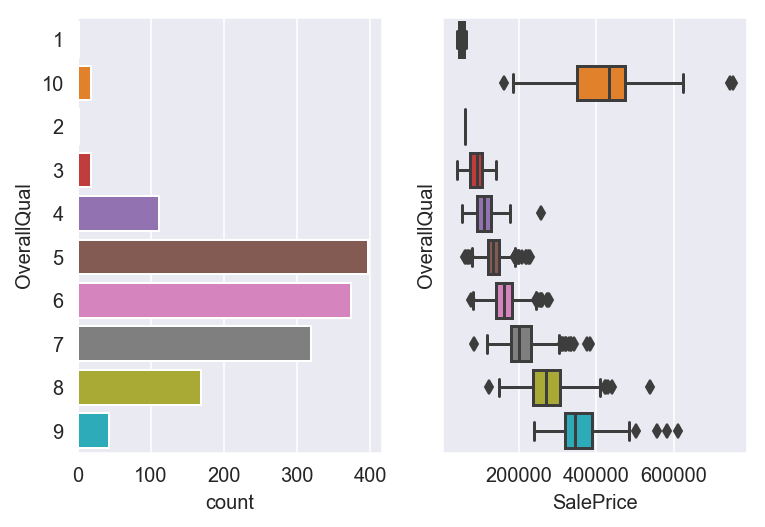

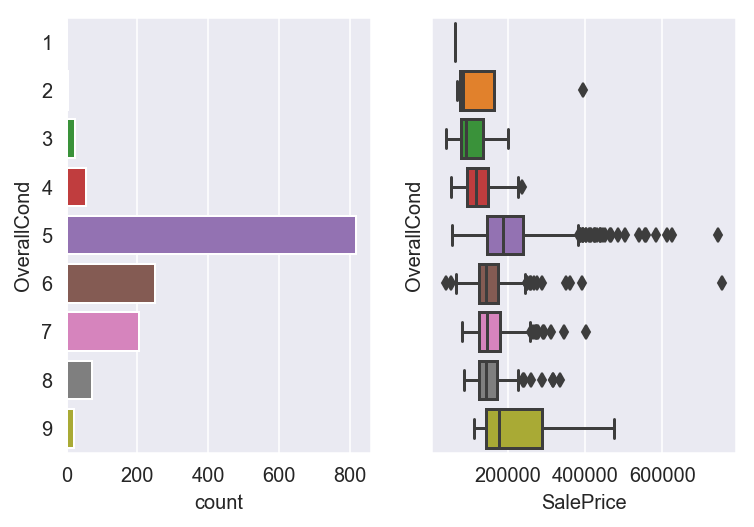

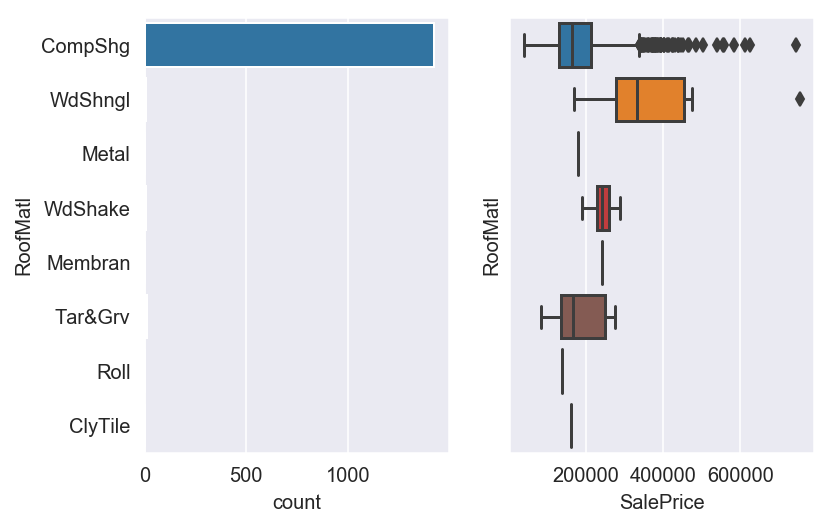

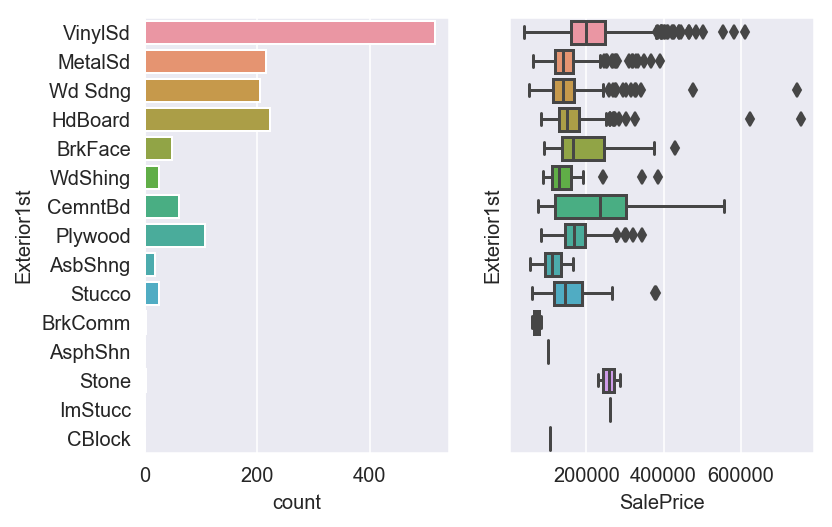

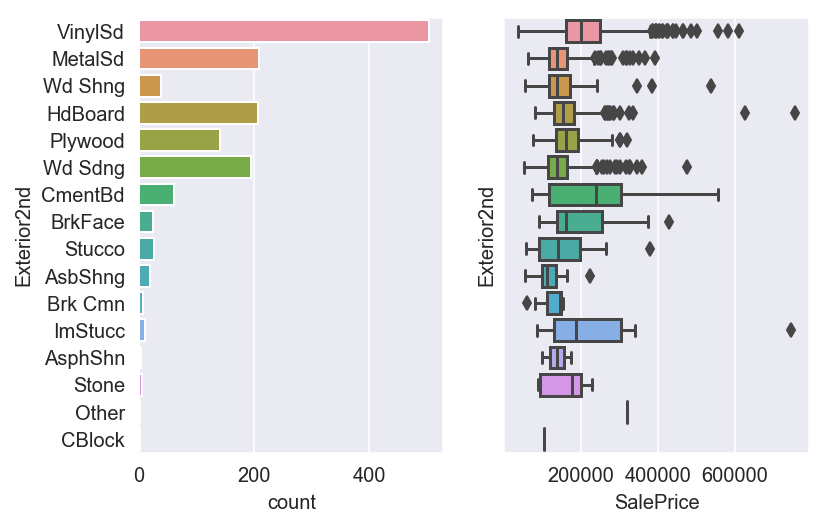

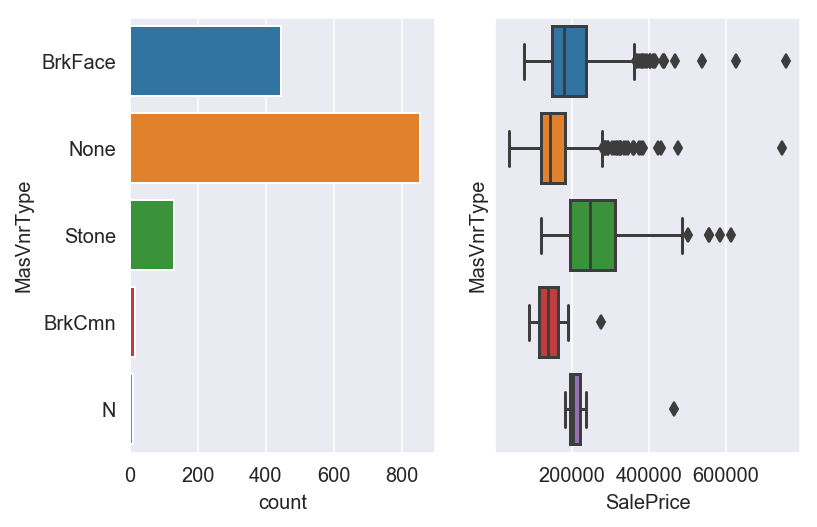

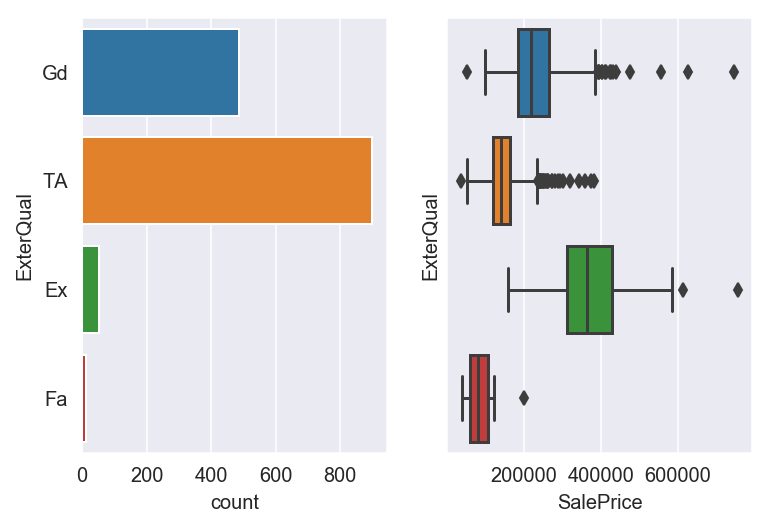

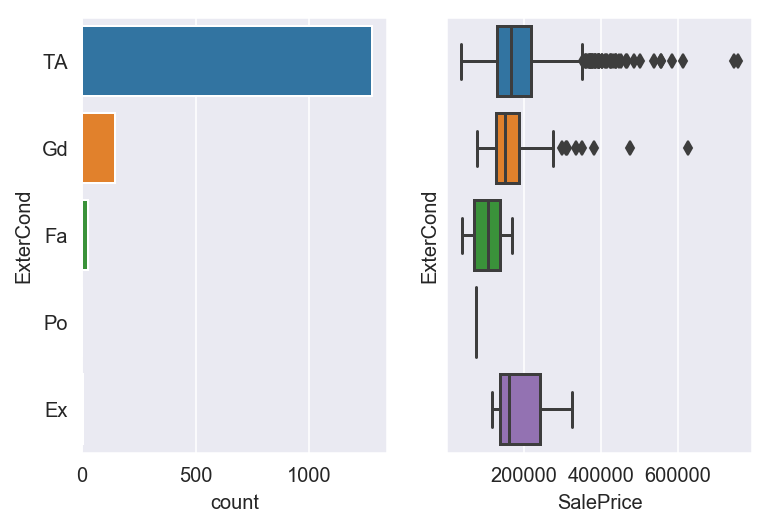

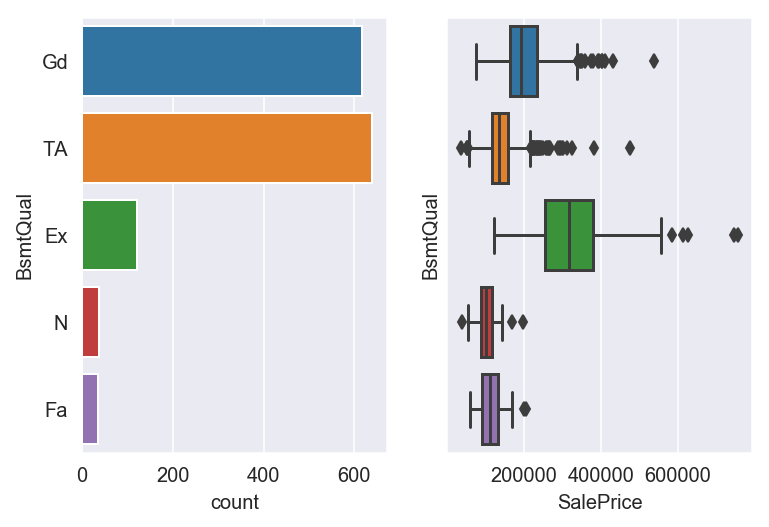

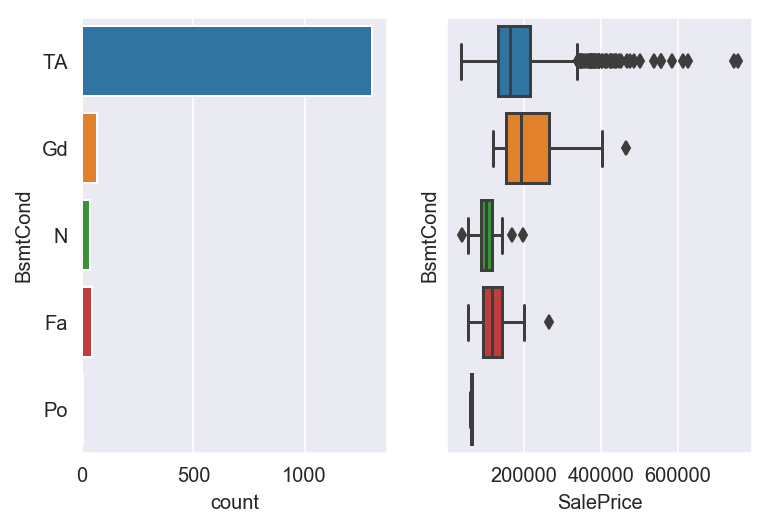

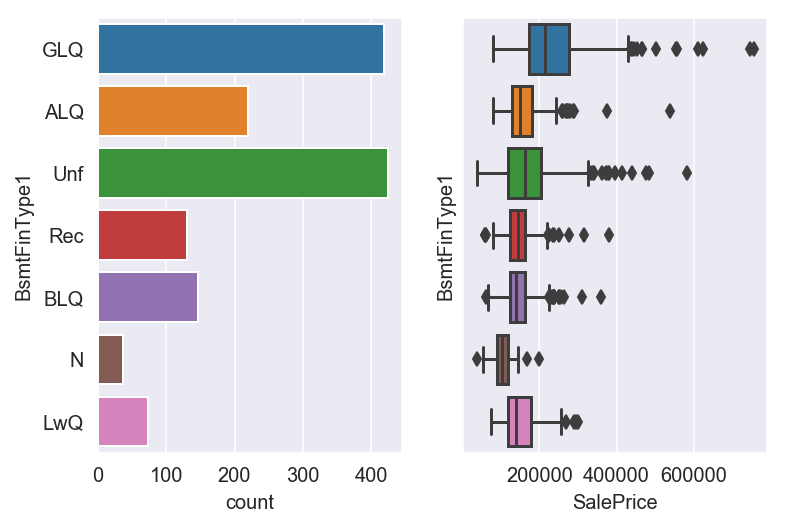

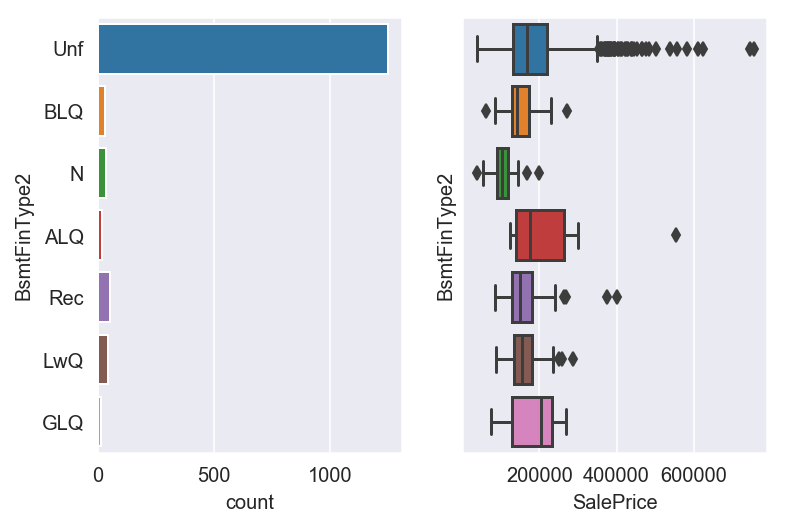

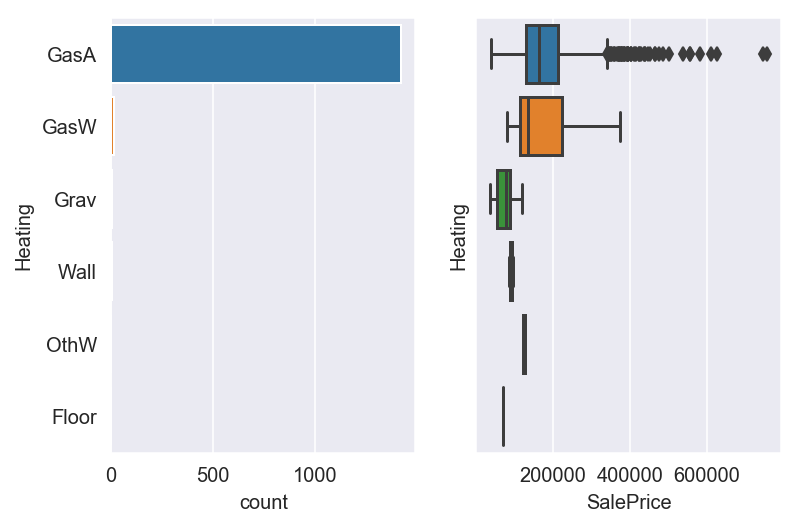

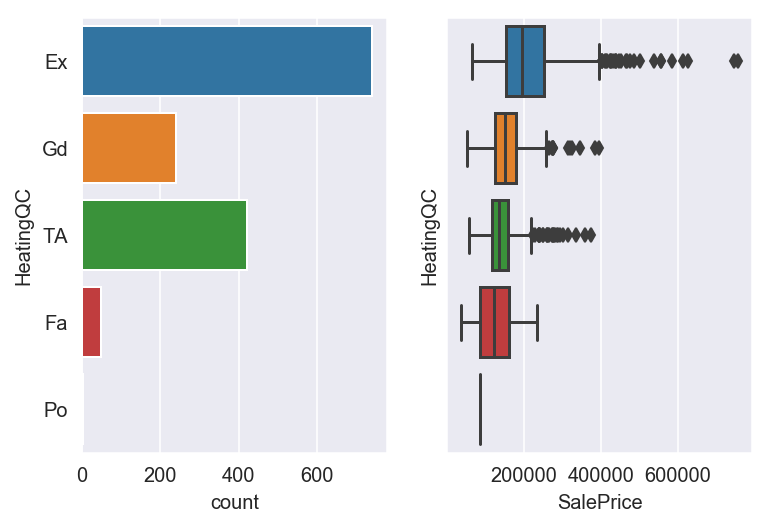

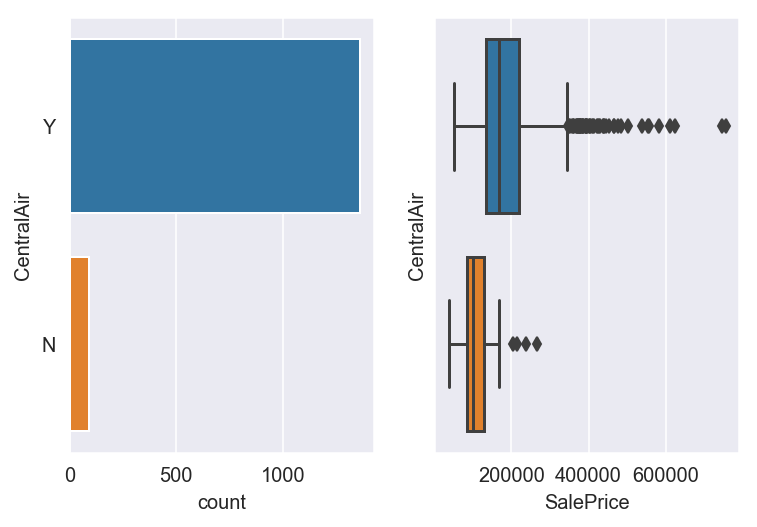

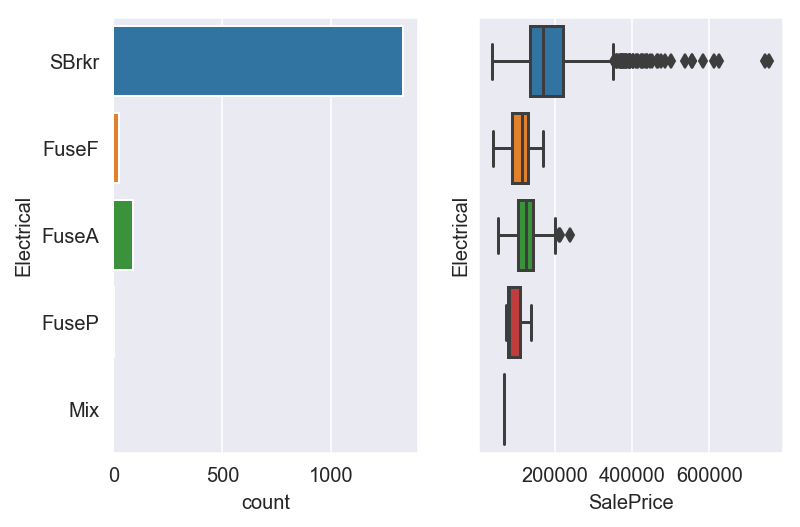

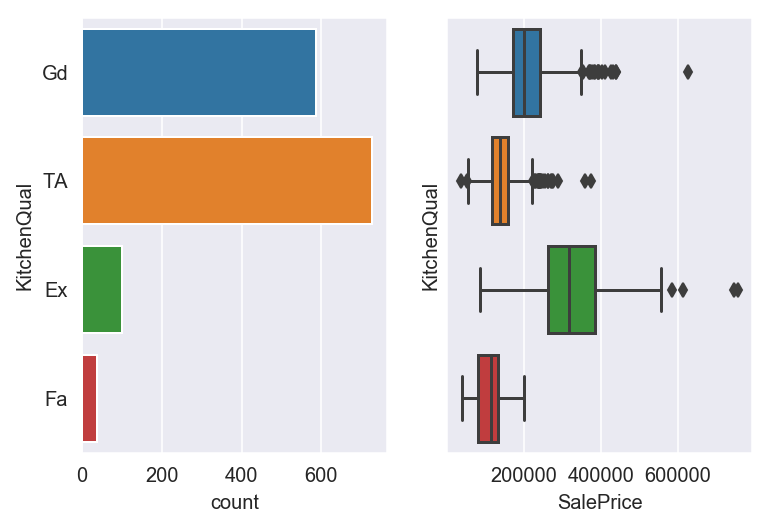

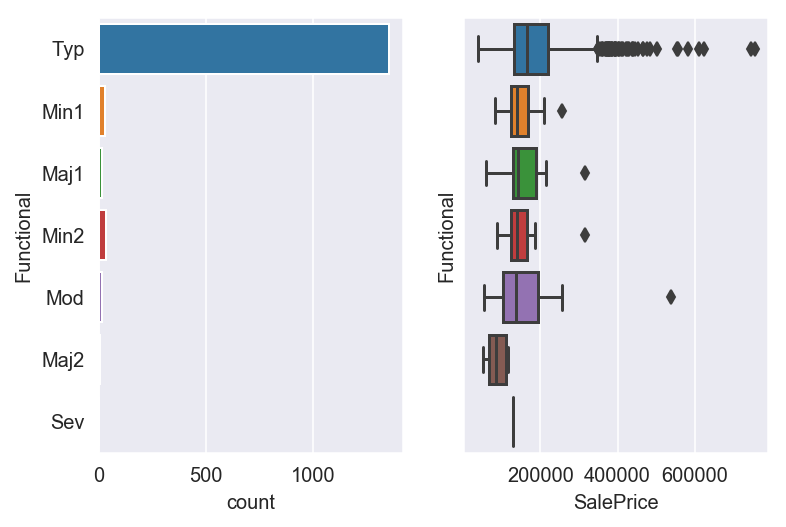

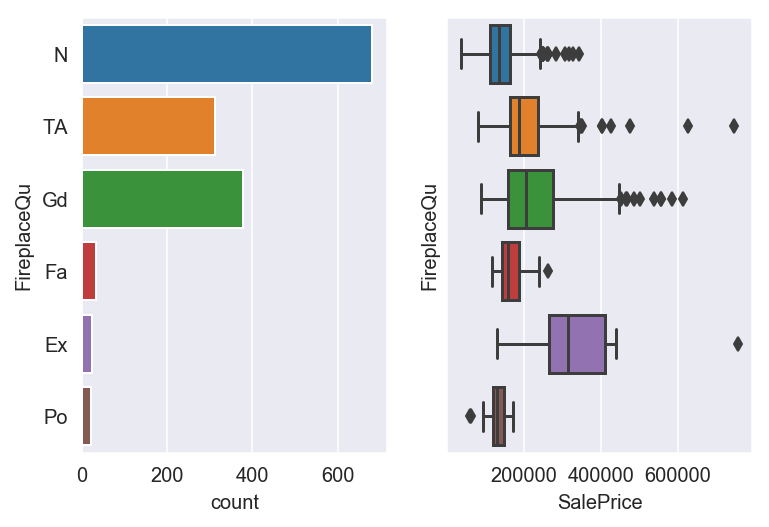

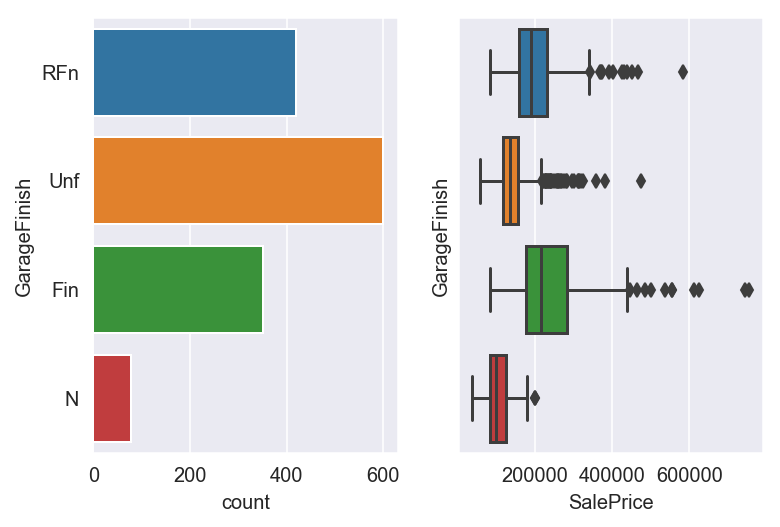

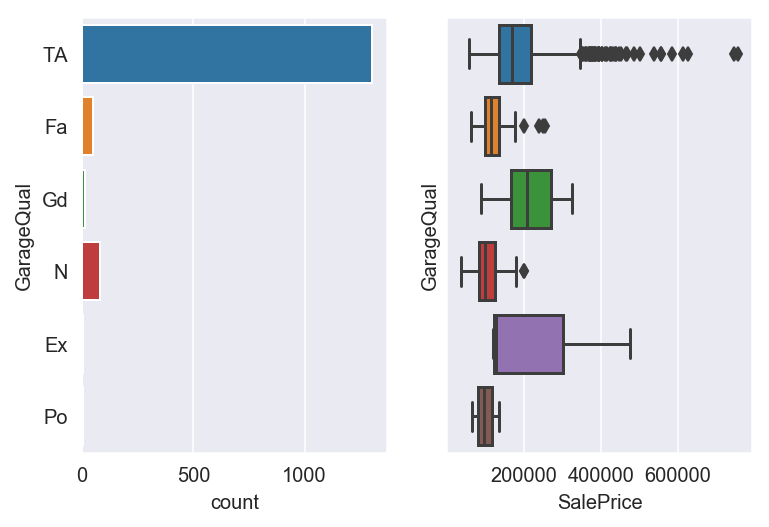

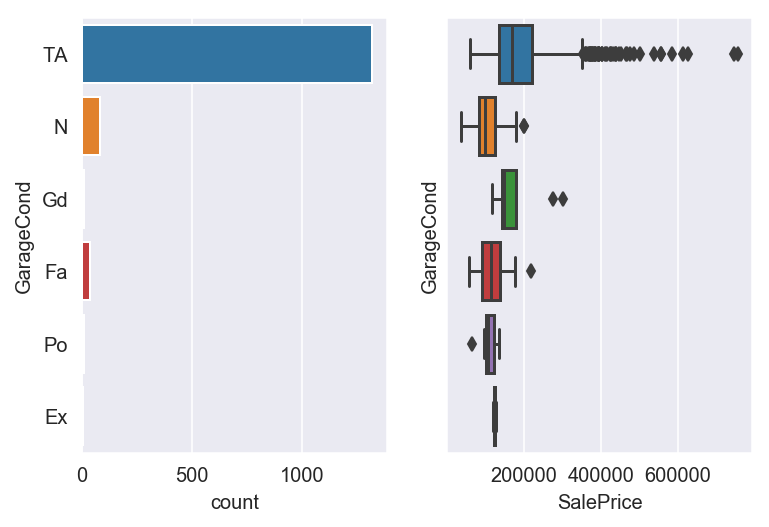

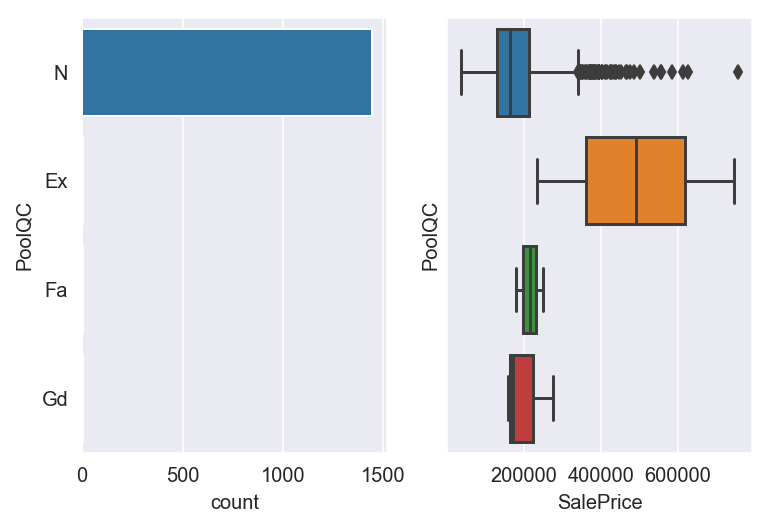

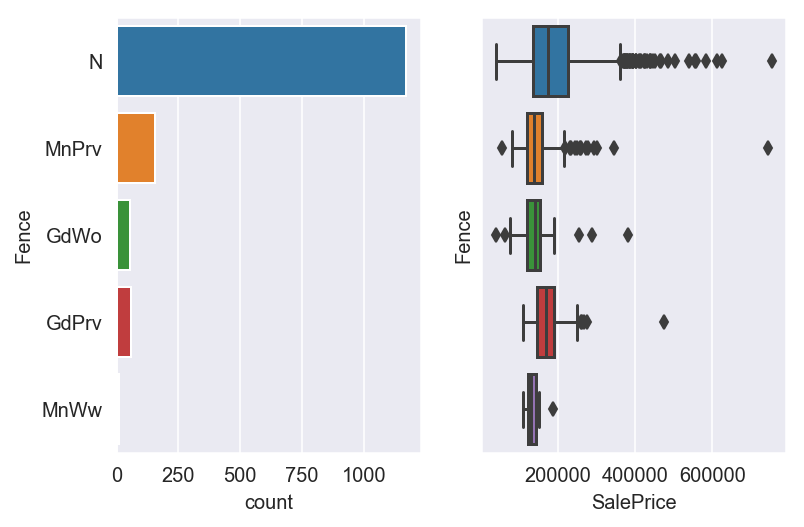

In [202]:
#explore the variables and it's relationship with sale price
for i in categorical:
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
    sns.countplot(y = changeable_df[i] , ax=ax1)
    sns.boxplot(x= house['SalePrice'],y= changeable_df[i],orient ='h' , ax = ax2)

In [203]:
# Decided to drop RoofMatl,Heating,Electrical,PoolQC,Fence,Functional.
# There's very low variance in the columns. 
drop_list=['RoofMatl','Heating','Electrical','PoolQC','Fence','Functional','GarageCond']
changeable_df = changeable_df.drop(columns = drop_list )


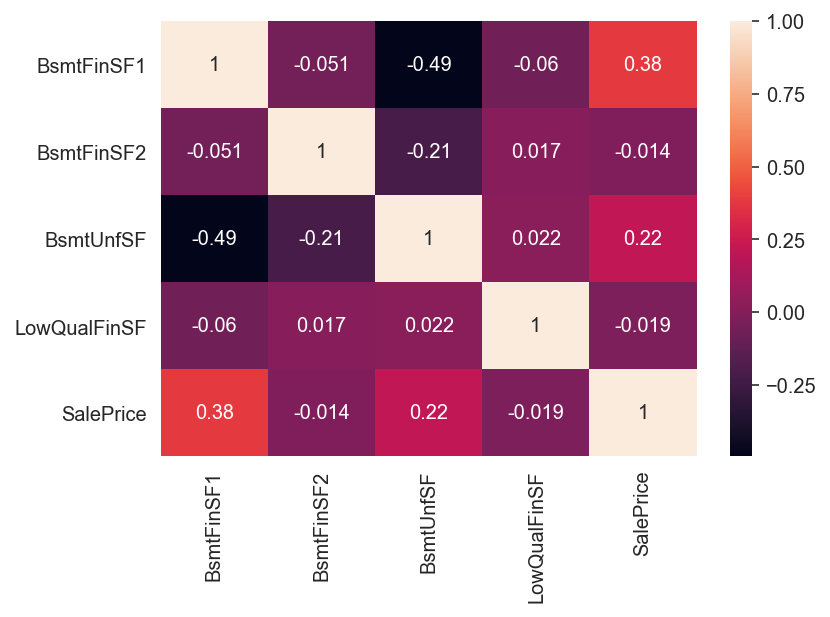

In [204]:
#plot the correlation heatmap for continuous variables against sale price
corr_df = pd.concat([changeable_df,house[['SalePrice']]],axis=1)
sns.heatmap(corr_df.corr(),annot=True)

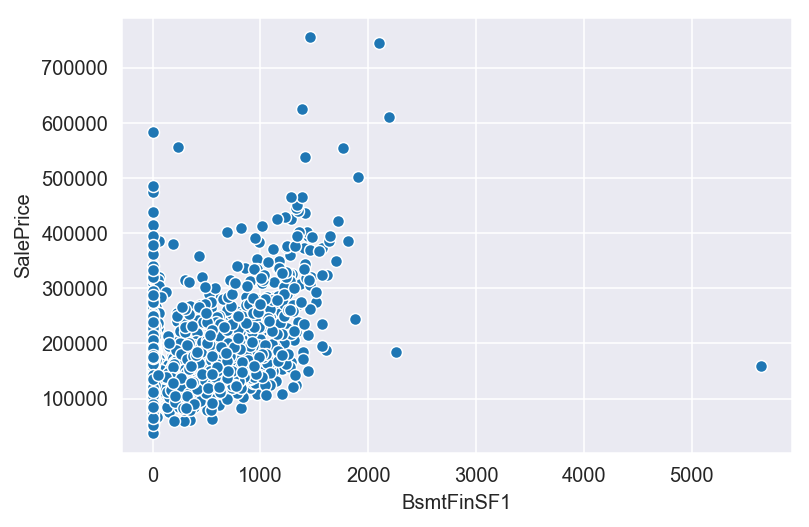

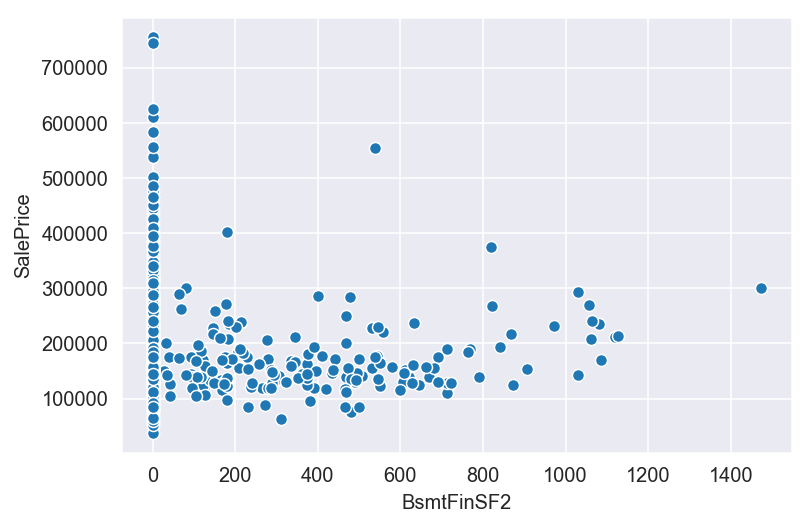

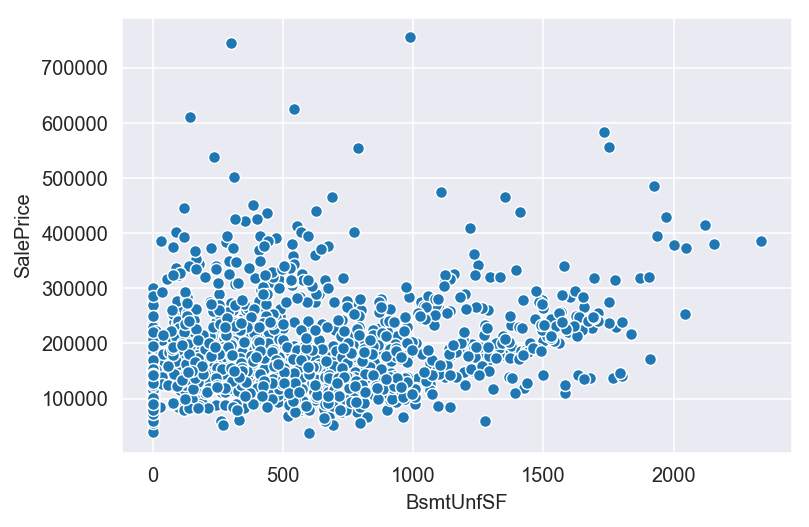

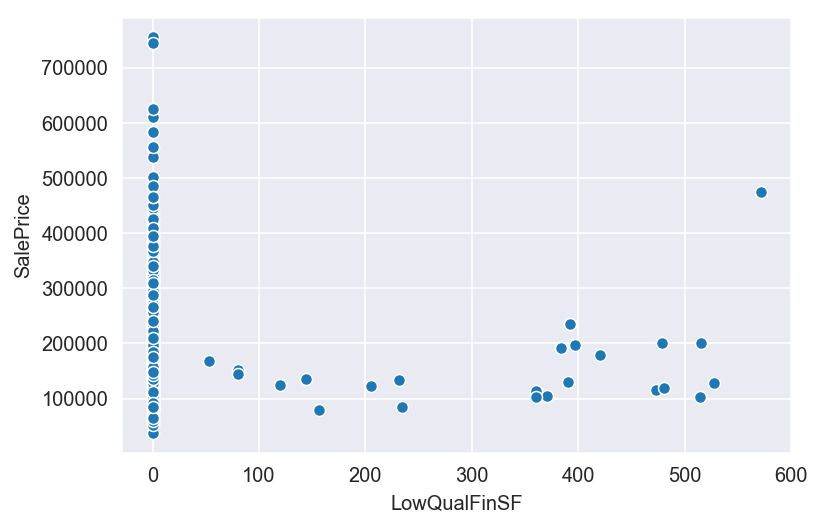

In [205]:
continuous = list(changeable_df.select_dtypes(include=['int64']).columns)

for i in continuous: 
    sns.scatterplot(x=changeable_df[i], y = house['SalePrice'])
    plt.show()

In [206]:
changeable_df.LowQualFinSF.value_counts()

0      1425
80        3
360       2
371       1
53        1
120       1
144       1
156       1
205       1
232       1
234       1
572       1
528       1
390       1
392       1
397       1
420       1
473       1
479       1
481       1
514       1
515       1
384       1
Name: LowQualFinSF, dtype: int64

In [207]:
changeable_df.BsmtFinSF2.value_counts()

0       1283
180        5
374        3
551        2
93         2
468        2
147        2
480        2
539        2
712        2
117        2
279        2
96         2
391        2
287        2
290        2
294        2
64         2
41         2
182        2
469        2
228        1
208        1
210        1
211        1
202        1
215        1
193        1
219        1
184        1
258        1
230        1
232        1
239        1
240        1
264        1
273        1
276        1
306        1
311        1
324        1
334        1
181        1
1085       1
1120       1
125        1
28         1
32         1
35         1
40         1
68         1
80         1
81         1
105        1
106        1
108        1
110        1
119        1
121        1
123        1
127        1
177        1
128        1
132        1
139        1
144        1
149        1
150        1
163        1
165        1
168        1
169        1
173        1
174        1
344        1
175        1
336        1

In [208]:
#too many zero values. Decided to drop LowQualFinSF , BsmtFinSF2 . Correlation to price is very low too. 
changeable_df = changeable_df.drop(columns = ['LowQualFinSF','BsmtFinSF2'] )

In [209]:
#get list of categorical data that is left.
categorical = list(changeable_df.select_dtypes(include=['object']).columns)
categorical

['OverallQual',
 'OverallCond',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'BsmtFinType1',
 'BsmtFinType2',
 'HeatingQC',
 'CentralAir',
 'KitchenQual',
 'FireplaceQu',
 'GarageFinish',
 'GarageQual']

In [210]:
#apply get_dummies to categorical data
df_dummies = pd.get_dummies(changeable_df[categorical], drop_first=True)

In [211]:
#drop the original categorical data since there is dummies now.
changeable_df= changeable_df.drop(columns = categorical)

In [212]:
#add dummies to the dataframe
changeable_df = pd.concat([changeable_df, df_dummies], axis=1)

In [213]:
#after get dummies is applied. There is 100 columns. 
len(changeable_df.columns)

100

In [214]:
#add YrSold column into Dataframe. In order to sort data by 2010 and before 2010.
changeable_df = pd.concat([changeable_df , house[['YrSold']]], axis =1)

In [215]:
#split data into 2010(test data) and before 2010(training data)
#our target is the residual from first model
changeable_df_test = changeable_df[changeable_df['YrSold'] == 2010]
#residual_2010= y_test.values.ravel()-y_test_predicted
y_test = residual_2010
X_test = changeable_df_test


changeable_df_train = changeable_df[changeable_df['YrSold'] < 2010]
#residual_train = y_train.values.ravel()-y_train_predicted
y_train = residual_train
X_train = changeable_df_train






In [216]:
#Apply selectKbest to get important features only. 

cols = list(X_train.columns)
# Build the selector — we'll build one with each score type.
skb_f = SelectKBest(f_regression)

# Train the selector on the data.
skb_f.fit(X_train, y_train)

# Examine the results.
kbest = pd.DataFrame([cols, list(skb_f.scores_),list(skb_f.pvalues_)], 
                     index=['feature','f_regression','p_values']).T.sort_values\
                     ('f_regression', ascending=False)

#select only variables with p-value lower than 0.05
significant = kbest[kbest['p_values']<0.05]
significant

c:\users\chenz\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
c:\users\chenz\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
c:\users\chenz\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
c:\users\chenz\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,feature,f_regression,p_values
10,OverallQual_9,77.8701,3.55004e-18
2,OverallQual_10,49.8591,2.70647e-12
68,BsmtFinType1_GLQ,15.3535,9.38837e-05
18,OverallCond_9,14.99,0.000113553
21,Exterior1st_BrkFace,14.7145,0.000131192
12,OverallCond_3,13.6087,0.000234618
60,BsmtQual_Gd,12.2368,0.000484683
54,ExterQual_TA,10.9301,0.000972439
13,OverallCond_4,9.8943,0.00169622
86,KitchenQual_TA,9.42843,0.00218161


In [217]:
#only 25 columns left after removing all that is not significant.
print(significant.shape)

(25, 3)


In [218]:
#group all features by increment of 10 features each time. 
#3 groups of features. 10 features , 20 features , 25 features.
top_list=[]
for i in range(10,40,10):
    top =[]
    top = list(significant.feature.head(i))
    top_list.append(top)
len(top_list)

3

In [219]:
#Apply linear regression model on the features selected by using kbest_f_regression
#Run through different number of features. 
for ls in top_list:
    print("===",len(ls), "Features===")
#     Xs = ss.fit_transform(X_train[ls])
#     Xs_test = ss.transform(X_test[ls])
    X_train_ = X_train[ls]
    X_test_ = X_test[ls]
    model = LinearRegression()
    # Perform cross-validation
    scores = cross_val_score(model,X_train_, y_train, cv=10)
    print("Cross-validated scores:", scores)
    print("Mean CV R2:", np.mean(scores))
    print('Std CV R2:', np.std(scores))

    model.fit(X_train_,y_train)

    print("Test Score:" ,model.score(X_test_,y_test))
    print("")

=== 10 Features===
Cross-validated scores: [ 0.08843842  0.30479379  0.14168814 -0.14209125  0.19028406  0.21581412
  0.15131276  0.23452482  0.05151809  0.1097115 ]
Mean CV R2: 0.13459944490451606
Std CV R2: 0.11627032305980418
Test Score: 0.20312136311514783

=== 20 Features===
Cross-validated scores: [ 0.06257663  0.26504161  0.15929249 -0.15693123  0.18607326  0.12866815
  0.1960026   0.21606545  0.04354541  0.15015225]
Mean CV R2: 0.12504866341736687
Std CV R2: 0.11336431082809656
Test Score: 0.16819207511127054

=== 25 Features===
Cross-validated scores: [-0.09310129  0.23635632  0.12213636 -0.12629767  0.17285297  0.12773977
  0.09729888  0.24540798  0.00652769  0.11279275]
Mean CV R2: 0.09017137605355671
Std CV R2: 0.11947566324722612
Test Score: 0.11633658361515219



Test score turn out to be very poor. Try scaling to check if result will be better.

In [220]:
#Apply linear regression model on the features selected by using kbest_f_regression
#Run through different number of features. 
for ls in top_list:
    print("===",len(ls), "Features===")
    Xs_train = ss.fit_transform(X_train[ls])
    Xs_test = ss.transform(X_test[ls])
#     X_train_ = X_train[ls]
#     X_test_ = X_test[ls]
    model = LinearRegression()
    # Perform cross-validation
    scores = cross_val_score(model,Xs_train, y_train, cv=10)
    print("Cross-validated scores:", scores)
    print("Mean CV R2:", np.mean(scores))
    print('Std CV R2:', np.std(scores))

    model.fit(Xs_train,y_train)

    print("Test Score:" ,model.score(Xs_test,y_test))
    print("")

=== 10 Features===
Cross-validated scores: [ 0.08843842  0.30479379  0.14168814 -0.14209125  0.19028406  0.21581412
  0.15131276  0.23452482  0.05151809  0.1097115 ]
Mean CV R2: 0.13459944490451597
Std CV R2: 0.11627032305980413
Test Score: 0.20312136311514795

=== 20 Features===
Cross-validated scores: [ 6.25766347e-02  2.65041611e-01  1.59292487e-01 -1.56931231e-01
 -5.35812331e+22  1.28668155e-01  1.96002605e-01  2.16065455e-01
  4.35454120e-02  1.50152247e-01]
Mean CV R2: -5.35812330565695e+21
Std CV R2: 1.607436991697085e+22
Test Score: 0.16819207511127077

=== 25 Features===
Cross-validated scores: [-9.31012874e-02  2.36356317e-01  1.22136364e-01 -1.26297667e-01
 -8.63703395e+23  1.27739765e-01  9.72988799e-02  2.45407979e-01
  6.52768542e-03  1.12792753e-01]
Mean CV R2: -8.63703395319547e+22
Std CV R2: 2.5911101859586413e+23
Test Score: 0.11633658361516719



Test score is still very poor after scaling.Try lasso model to see if there is any improvement. 

In [221]:
#find optimal alpha from lassocv
optimal_lasso = LassoCV(n_alphas=500, cv=10)
optimal_lasso.fit(Xs_train, y_train)
print(optimal_lasso.alpha_)

793.2110535985479


In [222]:
lasso = Lasso(alpha=optimal_lasso.alpha_)
lasso_scores = cross_val_score(lasso, Xs_train, y_train, cv=10)
lasso.fit(Xs_train,y_train)
lasso.score(Xs_test,y_test)

0.1746989240782666

In [228]:
print("Cross-validated scores:", lasso_scores)
print("Mean CV R2:", np.mean(lasso_scores))
print('Std CV R2:', np.std(lasso_scores))
print("Test Score:" ,lasso.score(Xs_test,y_test))

lasso_coefs = pd.DataFrame({'variable':X_train[top_list[-1]].columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs[lasso_coefs['abs_coef']!=0].sort_values(by='abs_coef',ascending = False)

Cross-validated scores: [ 0.01844413  0.24768338  0.15545107 -0.10462452  0.1672284   0.17140092
  0.20141236  0.2239696   0.01019272  0.14454763]
Mean CV R2: 0.12357056989148116
Std CV R2: 0.10638259015645159
Test Score: 0.1746989240782666


,abs_coef,coef,variable
0,7123.388588,7123.388588,OverallQual_9
1,5571.678029,5571.678029,OverallQual_10
4,2812.017612,2812.017612,Exterior1st_BrkFace
3,2371.503536,2371.503536,OverallCond_9
16,2242.965885,2242.965885,OverallCond_7
21,2181.024450,2181.024450,OverallQual_8
10,2095.491090,-2095.491090,BsmtFinType1_Unf
5,2060.097402,-2060.097402,OverallCond_3
14,1677.338289,-1677.338289,Exterior2nd_Stucco
22,1663.435408,-1663.435408,BsmtFinSF1


In [224]:
predicted = lasso.predict(Xs_train)
len(predicted)

1278

In [229]:
#check the values of predicted vs train
Check_df = pd.DataFrame()
Check_df['Actual'] = residual_train
Check_df['Predicted'] = predicted
Check_df.head()


,Actual,Predicted
0,8599.149031,-3936.538533
1,-15178.322679,-8430.664013
2,6460.634172,-3773.010169
3,-58002.780271,-2890.322509
4,-66410.628312,2352.692949


In [240]:
from sklearn.metrics import mean_squared_error
from math import sqrt

mse =mean_squared_error(Check_df['Actual'] ,Check_df['Predicted'], sample_weight=None, multioutput='uniform_average')

rootMeanSquaredError=sqrt(mse)
print("MSE:", mse)
print("RMSE:", rootMeanSquaredError)

MSE: 872614991.2168567
RMSE: 29540.05740036496


Lasso also gave a very bad score. The RMSE is very high. 
Model using residual of model 1 is not recommended. 

Conclusion :

**Evaluate the effect in dollars of the renovate-able features.

By analysing the coefficient of the features, "overall condition" of the house has the biggest effect over the sale price. 

**How would your company use this second model and its coefficients to determine whether they should buy a property or not?

By shortlisting houses that has very low "overall condition" score. From the coefficient, a improvement from score of 3 to score of 9, will increase the sale price by about $ 9,000.

**Explain how the company can use the two models you have built to determine if they can make money.

The first model will give a baseline of how much the sale price of a house will be. By using that base line, look for houses that are selling below the baseline. Then look at the second models coefficient to analyse how much potentially the sale price can be increase after renovations of a few top features.

For example : 

House is selling for $ 250,000

Predicted sale price from model 1 :$ 300,000

Example : House has a overall condition of 3. Renovate to overall condition of 9.

Resell house for $ 260,000 to $ 300,000. 

**Investigate how much of the variance in price remaining is explained by these features**

The variance in price is not explained well by the 2nd model. As the RSME is too high.

**Do you trust your model? Should it be used to evaluate which properties to buy and fix up?**

The model should not be used to evaluate which properties to buy and fix up. 
First of all, the score for model 2 is too low.

Secondly, there are many other factors that will affect sale prices , and they are not provided. Information such as , financial crisis years , Bank loan interest , Plans for the estate , Facilities/Amenities nearby(such as Subway station . Supermarts)  

Thirdly, the RSME for both model is too high. There is a high risk that the company will buy the house for a higher price by close to $30,000(base on model 1 RMSE: 30638.321045963097)

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [109]:
# A: